## Download dataset

In [ ]:
import requests
url = 'https://github.com/FlowFrontiers/IFLforTFC/raw/main/datasets/dataset.parquet'
response = requests.get(url)
with open('dataset.parquet', 'wb') as file:
    file.write(response.content)
    print("Parquet file 'dataset.parquet' downloaded successfully!")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

Parquet file 'dataset.parquet' downloaded successfully!


## Input data type analysis

In [1]:
import pandas as pd
df = pd.read_parquet("dataset.parquet")
# print(df.info())  # shows column dtypes

compressible_features = [
    'bidirectional_duration_ms', 'bidirectional_packets', 'bidirectional_bytes',
    'src2dst_duration_ms', 'src2dst_packets', 'src2dst_bytes',
    'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
    'bidirectional_min_ps', 'bidirectional_mean_ps', 'bidirectional_stddev_ps', 'bidirectional_max_ps',
    'src2dst_min_ps', 'src2dst_mean_ps', 'src2dst_stddev_ps', 'src2dst_max_ps',
    'dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps', 'dst2src_max_ps'
]

X = df[compressible_features].copy()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3163462 entries, 0 to 3163461
Data columns (total 21 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   bidirectional_duration_ms  int32  
 1   bidirectional_packets      int32  
 2   bidirectional_bytes        int64  
 3   src2dst_duration_ms        int32  
 4   src2dst_packets            int32  
 5   src2dst_bytes              int64  
 6   dst2src_duration_ms        int32  
 7   dst2src_packets            int32  
 8   dst2src_bytes              int64  
 9   bidirectional_min_ps       int16  
 10  bidirectional_mean_ps      float32
 11  bidirectional_stddev_ps    float32
 12  bidirectional_max_ps       int16  
 13  src2dst_min_ps             int16  
 14  src2dst_mean_ps            float32
 15  src2dst_stddev_ps          float32
 16  src2dst_max_ps             int16  
 17  dst2src_min_ps             int16  
 18  dst2src_mean_ps            float32
 19  dst2src_stddev_ps          float32
 20  ds

In [2]:
# Get maximum values for all columns
max_values = X.max()

# Display max values with column names
for column, max_val in max_values.items():
    print(f"{column:<25} {max_val:,.2f}")

bidirectional_duration_ms 1,799,999.00
bidirectional_packets     14,224,834.00
bidirectional_bytes       12,053,777,631.00
src2dst_duration_ms       1,799,999.00
src2dst_packets           7,813,814.00
src2dst_bytes             10,024,103,920.00
dst2src_duration_ms       1,799,998.00
dst2src_packets           6,411,020.00
dst2src_bytes             8,852,126,277.00
bidirectional_min_ps      1,514.00
bidirectional_mean_ps     1,514.00
bidirectional_stddev_ps   745.82
bidirectional_max_ps      1,529.00
src2dst_min_ps            1,514.00
src2dst_mean_ps           1,514.00
src2dst_stddev_ps         931.26
src2dst_max_ps            1,529.00
dst2src_min_ps            1,470.00
dst2src_mean_ps           1,513.98
dst2src_stddev_ps         866.21
dst2src_max_ps            1,528.00


1. For values with decimals (stddev_ps and mean_ps):
- Max value is around 1,514.00 with decimals
- Need: `float32` is sufficient (range ±3.4×10³⁸)

2. For the packet statistics (min_ps, max_ps):
- Max value around 1,529
- Need: `int16` is sufficient (range -32,768 to 32,767)

3. For duration_ms and packet counts:
- Max values around 1.8M (duration) and 14.2M (packets)
- Need: `int32` is sufficient (range ±2.1B)

4. For bytes columns:
- Max value around 12B (12,053,777,631)
- Need: `int64` since it exceeds `int32` max value (2.1B)

In [ ]:
# # Float32 columns (decimals)
# float32_cols = ['bidirectional_mean_ps', 'bidirectional_stddev_ps', 
#                 'src2dst_mean_ps', 'src2dst_stddev_ps',
#                 'dst2src_mean_ps', 'dst2src_stddev_ps']

# # Int16 columns (small integers)
# int16_cols = ['bidirectional_min_ps', 'bidirectional_max_ps',
#               'src2dst_min_ps', 'src2dst_max_ps',
#               'dst2src_min_ps', 'dst2src_max_ps']

# # Int32 columns (medium integers)
# int32_cols = ['bidirectional_duration_ms', 'bidirectional_packets',
#               'src2dst_duration_ms', 'src2dst_packets',
#               'dst2src_duration_ms', 'dst2src_packets']

# # Int64 columns (large integers)
# int64_cols = ['bidirectional_bytes', 'src2dst_bytes', 'dst2src_bytes']

In [4]:
# # Cast all integer columns to int64
# int_columns = [
#     'bidirectional_duration_ms', 'bidirectional_packets', 'bidirectional_bytes',
#     'src2dst_duration_ms', 'src2dst_packets', 'src2dst_bytes',
#     'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
#     'bidirectional_min_ps', 'bidirectional_max_ps',
#     'src2dst_min_ps', 'src2dst_max_ps',
#     'dst2src_min_ps', 'dst2src_max_ps'
# ]

# # Cast all float columns to float64
# float_columns = [
#     'bidirectional_mean_ps', 'bidirectional_stddev_ps',
#     'src2dst_mean_ps', 'src2dst_stddev_ps',
#     'dst2src_mean_ps', 'dst2src_stddev_ps'
# ]

# # Apply the casting
# X[int_columns] = X[int_columns].astype('int64')
# X[float_columns] = X[float_columns].astype('float64')

## Compression

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from scipy.stats import entropy
from tqdm import tqdm
import time

def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

setup_seed(42)

# Base Autoencoder class
class BaseAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(BaseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, encoding_dim),
            nn.LeakyReLU(0.2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def train_autoencoder(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    test_losses = []

    for epoch in tqdm(range(num_epochs), desc='Training'):
        model.train()
        train_loss = 0
        epoch_start = time.time()
        
        for data in train_loader:
            inputs = data[0]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            test_loss = sum(criterion(model(data[0]), data[0]).item() for data in test_loader) / len(test_loader)
        test_losses.append(test_loss)
        
        scheduler.step(test_loss)
        epoch_time = time.time() - epoch_start
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] ({epoch_time:.2f}s) - Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.2e}')

    return train_losses, test_losses

# Load and preprocess data
df = pd.read_parquet('dataset.parquet')
compressible_features = [
    'bidirectional_duration_ms', 'bidirectional_packets', 'bidirectional_bytes',
    'src2dst_duration_ms', 'src2dst_packets', 'src2dst_bytes',
    'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
    'bidirectional_min_ps', 'bidirectional_mean_ps', 'bidirectional_stddev_ps', 'bidirectional_max_ps',
    'src2dst_min_ps', 'src2dst_mean_ps', 'src2dst_stddev_ps', 'src2dst_max_ps',
    'dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps', 'dst2src_max_ps'
]

X = df[compressible_features].copy()

for column in X.columns:
    # threshold = X[column].quantile(0.999)
    # X.loc[:, column] = X[column].clip(upper=threshold) ### replaced with the below

    X[column] = X[column].clip(upper=X[column].quantile(0.999)).astype(X[column].dtype)
    # - Each column maintains its original dtype (int32, int64, or float32)
    # - The clipping operation happens in float64 precision
    # - The values are properly cast back to their original dtype before assignment

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
 # - Input features are mix of int32, int64, and float32 as we saw earlier
 # - RobustScaler typically outputs float64 by default
 # - X_scaled is float64 after scaling
 # - Converting to torch.FloatTensor makes it float32

X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)
X_train_tensor, X_test_tensor = map(torch.FloatTensor, (X_train, X_test)) # Converting to torch.FloatTensor makes it float32

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=64, shuffle=False)

# Train and evaluate vanilla autoencoder
print("\nTraining Vanilla Autoencoder")
input_dim = len(compressible_features)
encoding_dim = 16
model = BaseAutoencoder(input_dim, encoding_dim)

criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

train_losses, test_losses = train_autoencoder(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=200)


Training Vanilla Autoencoder


Training:   5%|█▌                            | 10/200 [04:00<1:15:33, 23.86s/it]

Epoch [10/200] (23.53s) - Train Loss: 0.1327, Val Loss: 0.1461, LR: 1.00e-03


Training:  10%|███                           | 20/200 [07:59<1:11:53, 23.96s/it]

Epoch [20/200] (24.12s) - Train Loss: 0.0621, Val Loss: 0.0858, LR: 5.00e-04


Training:  15%|████▌                         | 30/200 [12:22<1:18:40, 27.77s/it]

Epoch [30/200] (26.19s) - Train Loss: 0.0573, Val Loss: 0.0632, LR: 5.00e-04


Training:  20%|██████                        | 40/200 [16:29<1:05:19, 24.50s/it]

Epoch [40/200] (24.79s) - Train Loss: 0.0351, Val Loss: 0.0424, LR: 2.50e-04


Training:  25%|███████▌                      | 50/200 [21:03<1:09:15, 27.70s/it]

Epoch [50/200] (27.86s) - Train Loss: 0.0247, Val Loss: 0.0238, LR: 1.25e-04


Training:  30%|█████████                     | 60/200 [25:41<1:04:49, 27.78s/it]

Epoch [60/200] (27.60s) - Train Loss: 0.0243, Val Loss: 0.0237, LR: 6.25e-05


Training:  35%|██████████▌                   | 70/200 [30:19<1:00:17, 27.82s/it]

Epoch [70/200] (27.73s) - Train Loss: 0.0197, Val Loss: 0.0201, LR: 6.25e-05


Training:  40%|████████████▊                   | 80/200 [35:01<56:38, 28.32s/it]

Epoch [80/200] (28.28s) - Train Loss: 0.0176, Val Loss: 0.0192, LR: 3.13e-05


Training:  45%|██████████████▍                 | 90/200 [39:40<51:23, 28.03s/it]

Epoch [90/200] (28.32s) - Train Loss: 0.0166, Val Loss: 0.0170, LR: 1.56e-05


Training:  50%|███████████████▌               | 100/200 [44:19<46:37, 27.98s/it]

Epoch [100/200] (28.22s) - Train Loss: 0.0164, Val Loss: 0.0169, LR: 1.56e-05


Training:  55%|█████████████████              | 110/200 [49:01<42:32, 28.36s/it]

Epoch [110/200] (28.28s) - Train Loss: 0.0160, Val Loss: 0.0164, LR: 7.81e-06


Training:  60%|██████████████████▌            | 120/200 [53:38<36:54, 27.69s/it]

Epoch [120/200] (27.55s) - Train Loss: 0.0159, Val Loss: 0.0162, LR: 7.81e-06


Training:  65%|████████████████████▏          | 130/200 [58:16<32:16, 27.67s/it]

Epoch [130/200] (27.51s) - Train Loss: 0.0158, Val Loss: 0.0161, LR: 7.81e-06


Training:  70%|████████████████████▎        | 140/200 [1:02:54<27:44, 27.75s/it]

Epoch [140/200] (27.58s) - Train Loss: 0.0155, Val Loss: 0.0159, LR: 3.91e-06


Training:  75%|█████████████████████▊       | 150/200 [1:07:31<23:03, 27.66s/it]

Epoch [150/200] (27.54s) - Train Loss: 0.0154, Val Loss: 0.0157, LR: 3.91e-06


Training:  80%|███████████████████████▏     | 160/200 [1:12:09<18:24, 27.62s/it]

Epoch [160/200] (27.26s) - Train Loss: 0.0153, Val Loss: 0.0156, LR: 1.95e-06


Training:  85%|████████████████████████▋    | 170/200 [1:16:45<13:48, 27.62s/it]

Epoch [170/200] (27.71s) - Train Loss: 0.0153, Val Loss: 0.0155, LR: 1.95e-06


Training:  90%|██████████████████████████   | 180/200 [1:20:57<08:48, 26.43s/it]

Epoch [180/200] (27.44s) - Train Loss: 0.0152, Val Loss: 0.0155, LR: 1.95e-06


Training:  95%|███████████████████████████▌ | 190/200 [1:25:32<04:34, 27.42s/it]

Epoch [190/200] (27.25s) - Train Loss: 0.0152, Val Loss: 0.0154, LR: 1.95e-06


Training: 100%|█████████████████████████████| 200/200 [1:29:39<00:00, 26.90s/it]

Epoch [200/200] (22.85s) - Train Loss: 0.0151, Val Loss: 0.0154, LR: 1.95e-06


In [2]:
# # Calculate compression ratio
# with torch.no_grad():
#     latent_train = model.encoder(X_train_tensor).detach().cpu().numpy()

# # Memory size comparison
# original_size = X_train_tensor.numpy().nbytes  # float32 representation of X_train
# latent_size = latent_train.nbytes              # float32 representation of the latent space
# compression_ratio = original_size / latent_size
# print(f"Compression Ratio (Train): {compression_ratio:.2f}")

def get_compression_ratio(X_train, model, encoding_dim):
    # First calculate float64 size (transformed to float64 via via scaling)
    original_size = X_train.nbytes
    
    # Then calculate float32 size (downcasted to match tensor precision)
    X_train_float32 = X_train.astype(np.float32)
    original_size_32 = X_train_float32.nbytes
    
    # Get encoded representation (always in float32 due to PyTorch)
    with torch.no_grad():
        encoded = model.encoder(torch.FloatTensor(X_train)).detach().cpu().numpy()
    # encoded = model.encoder(torch.FloatTensor(X_train_float32)).detach().cpu().numpy()
    compressed_size = encoded.nbytes
    
    # Print detailed information about the data
    print(f"Original data type: {X_train.dtype}")
    print(f"Encoded data type: {encoded.dtype}")
    print(f"Original shape: {X_train_float32.shape}")
    print(f"Encoded shape: {encoded.shape}")
    print(f"Original size (64-bit): {original_size:,} bytes")
    print(f"Original size (32-bit): {original_size_32:,} bytes")
    print(f"Compressed size: {compressed_size:,} bytes")
    
    # Calculate both compression ratios
    ratio_64_to_32 = original_size / compressed_size
    ratio_32_to_32 = original_size_32 / compressed_size
    
    # Print the compression ratios with clear labels
    print("\nCompression Ratios:")
    print(f"64→32 (with precision reduction): {ratio_64_to_32:.3f}")
    print(f"32→32 (pure dimensionality reduction): {ratio_32_to_32:.3f}")
    
    # # Optional: Print the theoretical ratios for comparison
    # input_dim = X_train.shape[1]
    # print("\nTheoretical Ratios:")
    # print(f"64→32 theoretical: {(input_dim * 8)/(encoding_dim * 4):.3f}")
    # print(f"32→32 theoretical: {input_dim/encoding_dim:.3f}")

    return ratio_32_to_32

compression_ratio = get_compression_ratio(X_train, model, encoding_dim)

Original data type: float64
Encoded data type: float32
Original shape: (2530769, 21)
Encoded shape: (2530769, 16)
Original size (64-bit): 425,169,192 bytes
Original size (32-bit): 212,584,596 bytes
Compressed size: 161,969,216 bytes

Compression Ratios:
64→32 (with precision reduction): 2.625
32→32 (pure dimensionality reduction): 1.312


In [3]:
# Evaluate Reconstruction for X_test
model.eval()
with torch.no_grad():
    reconstructed_data = model(X_test_tensor).cpu().numpy()

# Inverse transform the data
reconstructed_data = scaler.inverse_transform(reconstructed_data)
X_test_original = scaler.inverse_transform(X_test)

# Calculate metrics
mse = np.mean((X_test_original - reconstructed_data) ** 2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((X_test_original - reconstructed_data) / (X_test_original + 1e-8))) * 100

# Feature-specific errors and KL divergences
feature_errors = {}
kl_divergences = {}
for i, feature in enumerate(compressible_features):
    percentage_error = np.median(np.abs((X_test_original[:, i] - reconstructed_data[:, i]) / (X_test_original[:, i] + 1e-8))) * 100
    feature_errors[feature] = float(percentage_error)

    original_hist, _ = np.histogram(X_test_original[:, i], bins=50, density=True)
    reconstructed_hist, _ = np.histogram(reconstructed_data[:, i], bins=50, density=True)
    original_hist = original_hist + 1e-10
    reconstructed_hist = reconstructed_hist + 1e-10
    kl_div = float(entropy(original_hist, reconstructed_hist))
    kl_divergences[feature] = kl_div

# Store results
results = {
    'vanilla': {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'mse': float(mse),
        'rmse': float(rmse),
        'mape': float(mape),
        'compression_ratio': float(compression_ratio),
        'feature_errors': feature_errors,
        'kl_divergences': kl_divergences
    }
}

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
    
# Save results to JSON (excluding the model)
with open('autoencoder_results.json', 'w') as f:
    json.dump({k: {sk: sv for sk, sv in v.items() if sk != 'model'} for k, v in results.items()}, f, indent=4)

print("Results saved successfully to JSON.")

# Save the model using PyTorch's save function
torch.save(results['vanilla']['model'].state_dict(), 'vanilla_model.pth')
print("Model saved successfully.")

# Save scaler
joblib.dump(scaler, 'robust_scaler.joblib')

# Save feature names
with open('feature_names.json', 'w') as f:
    json.dump(compressible_features, f)

print("Scaler and feature names saved successfully.")

MSE: 1378626865.5184
RMSE: 37129.8649
MAPE: 3071189490.36%
Results saved successfully to JSON.
Model saved successfully.
Scaler and feature names saved successfully.


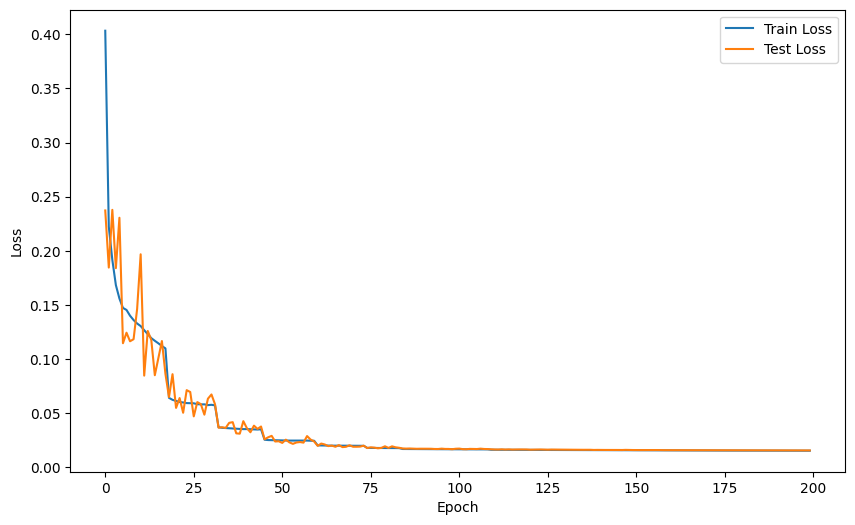

<Figure size 1200x800 with 0 Axes>

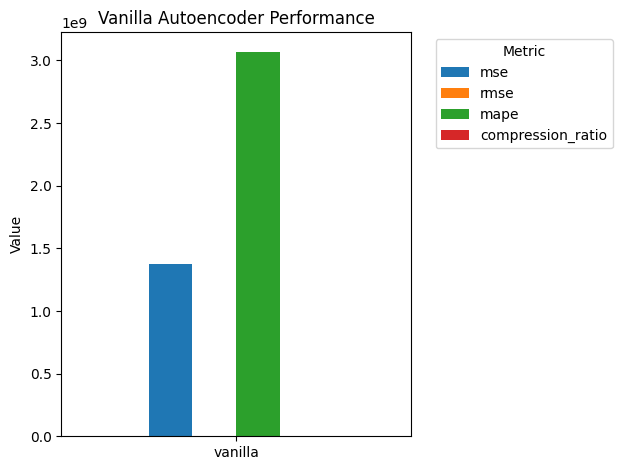

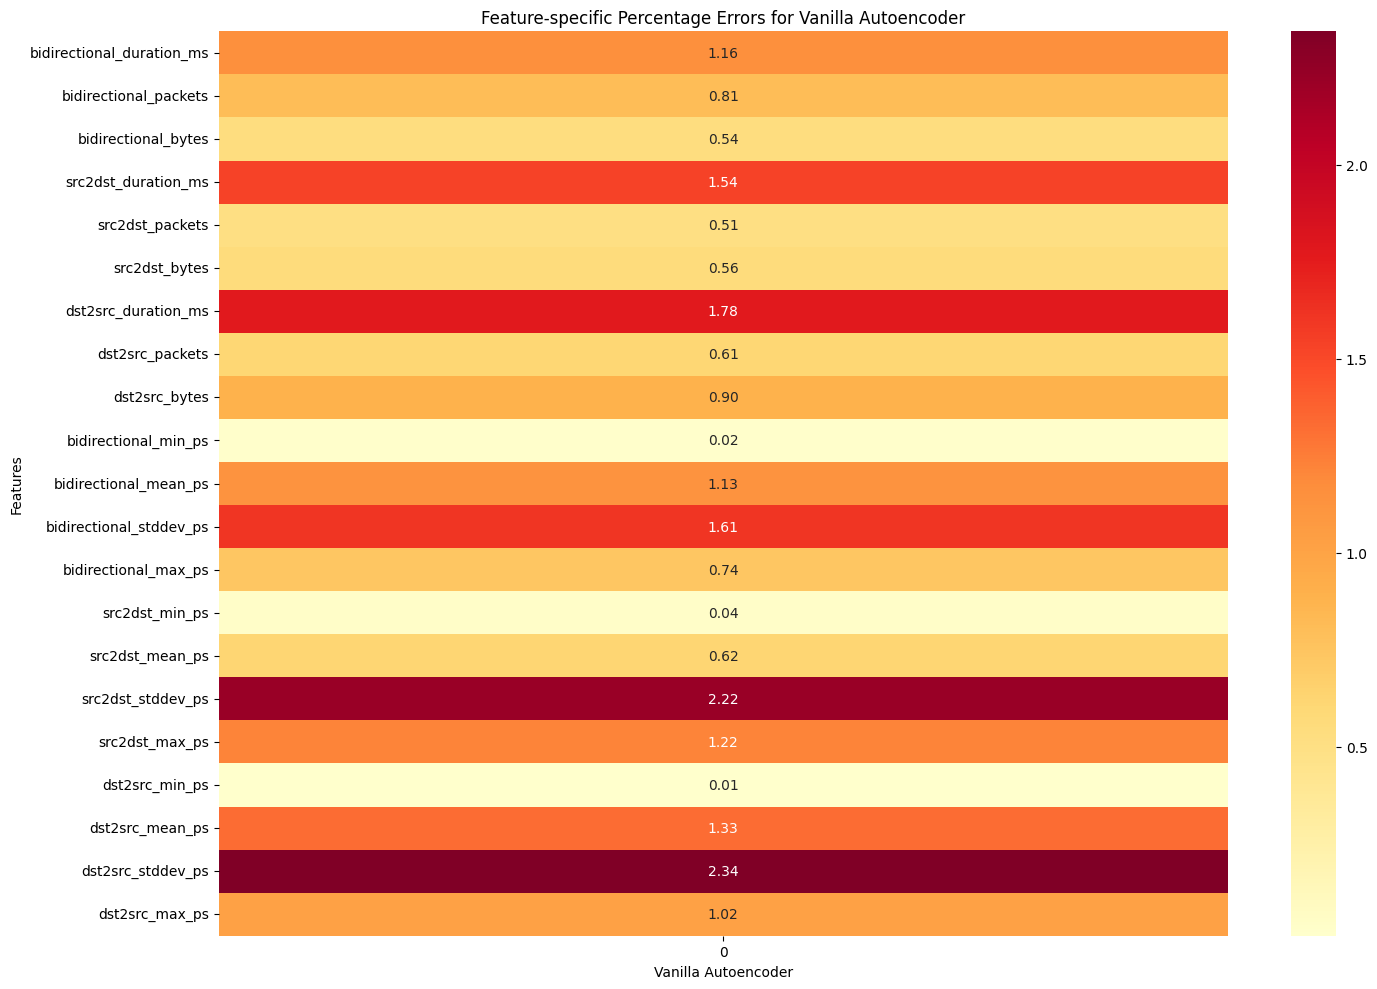

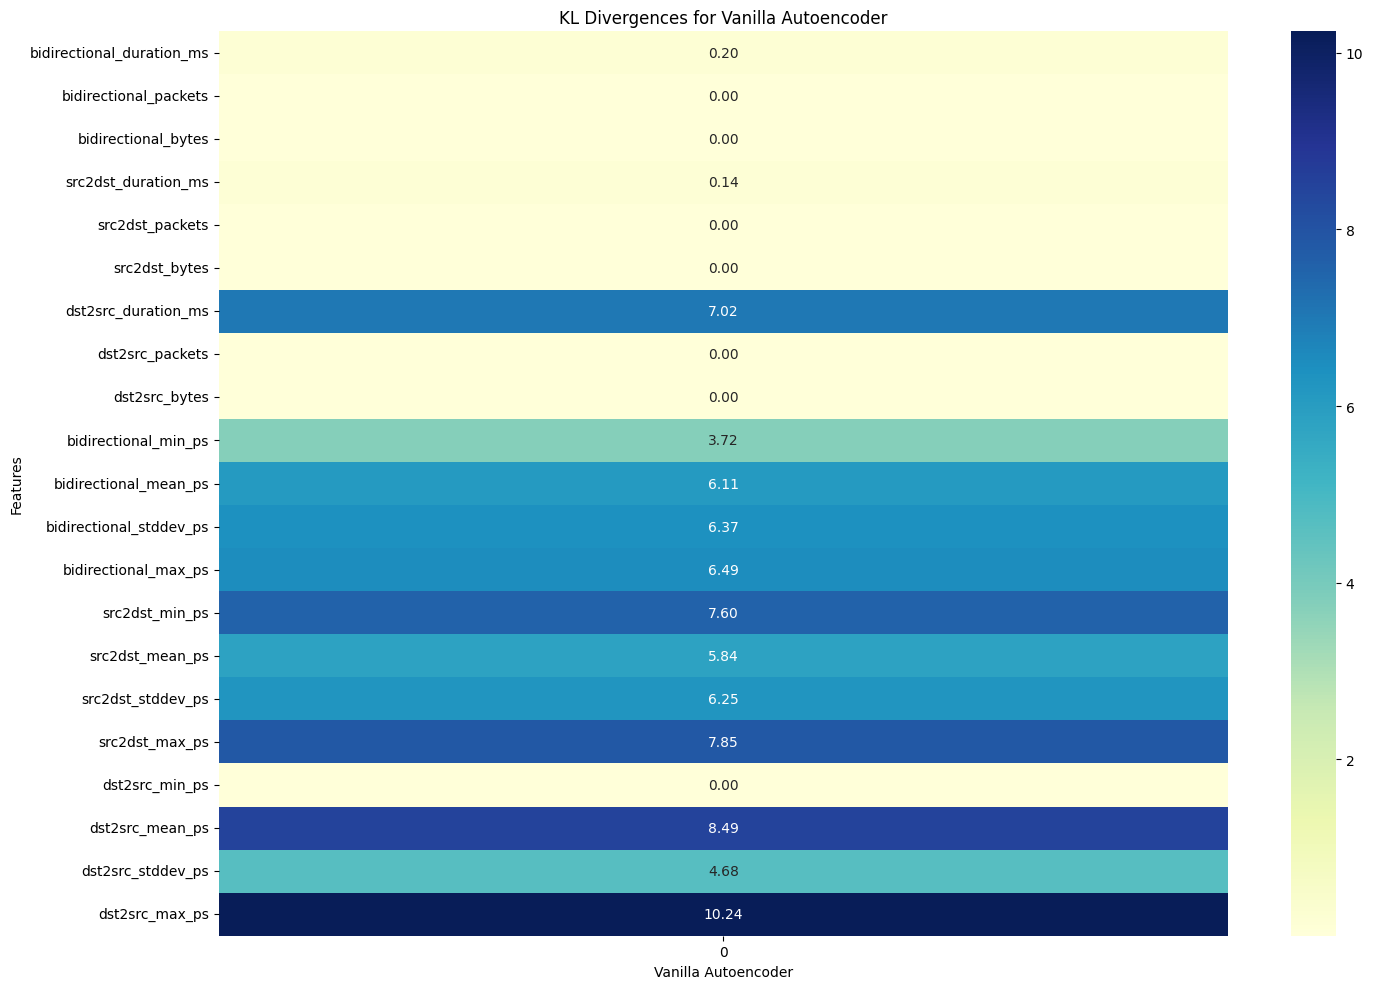

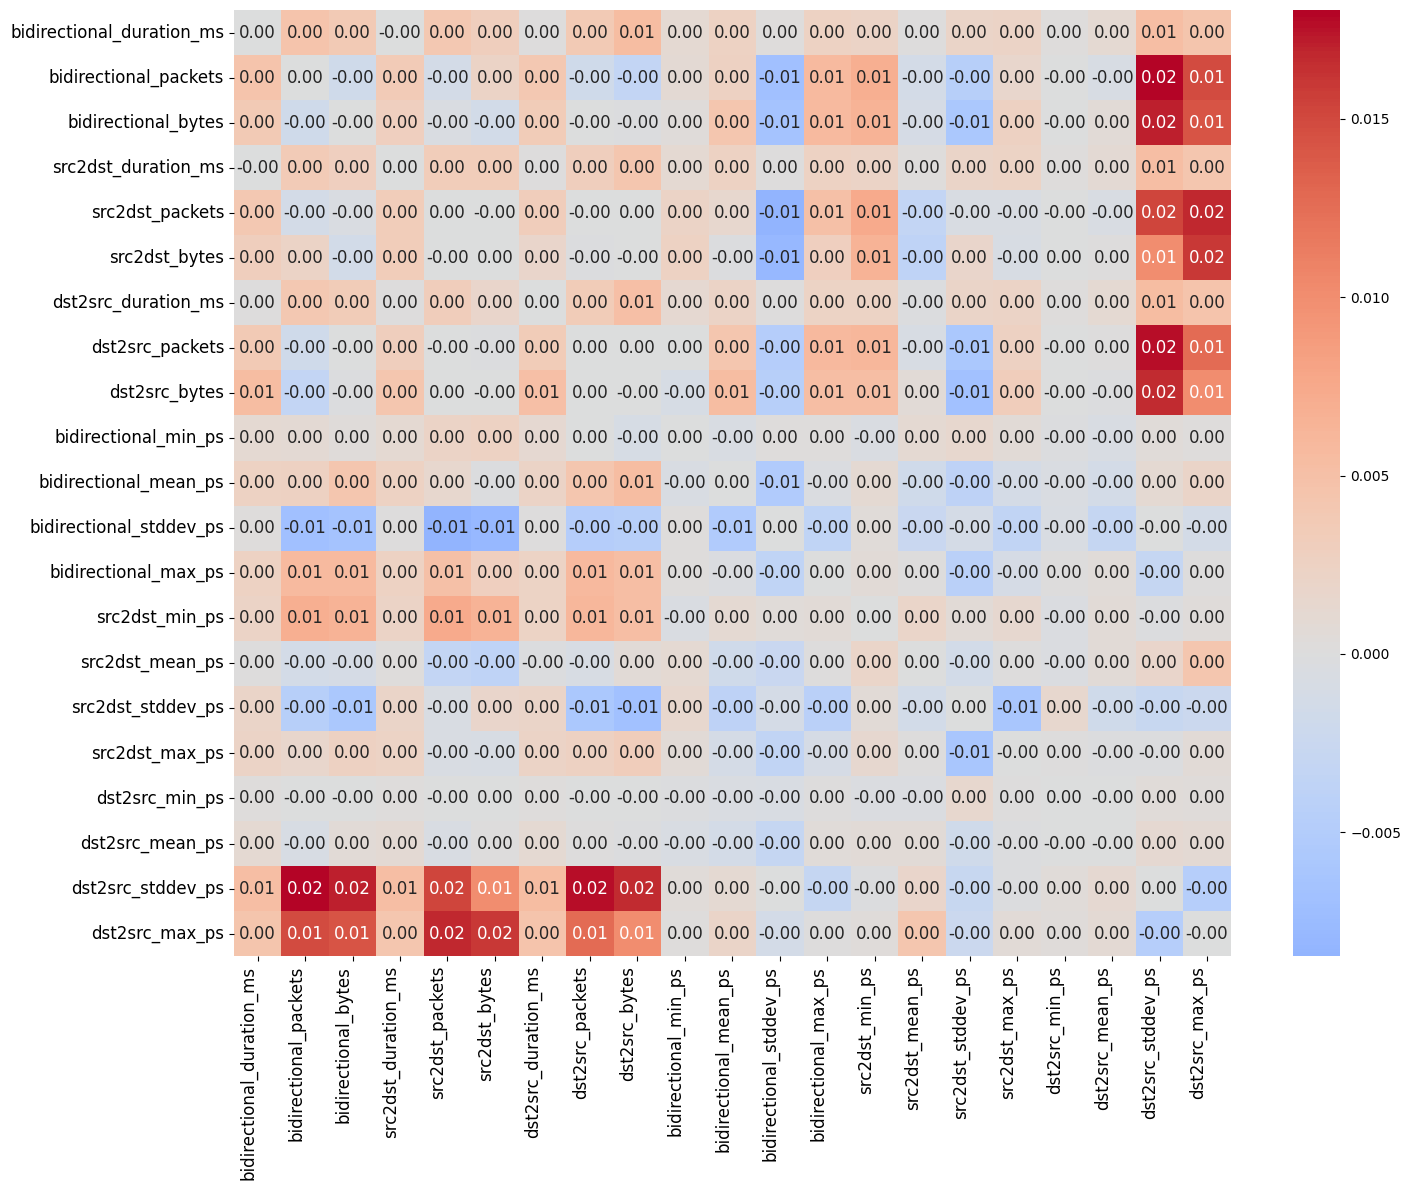

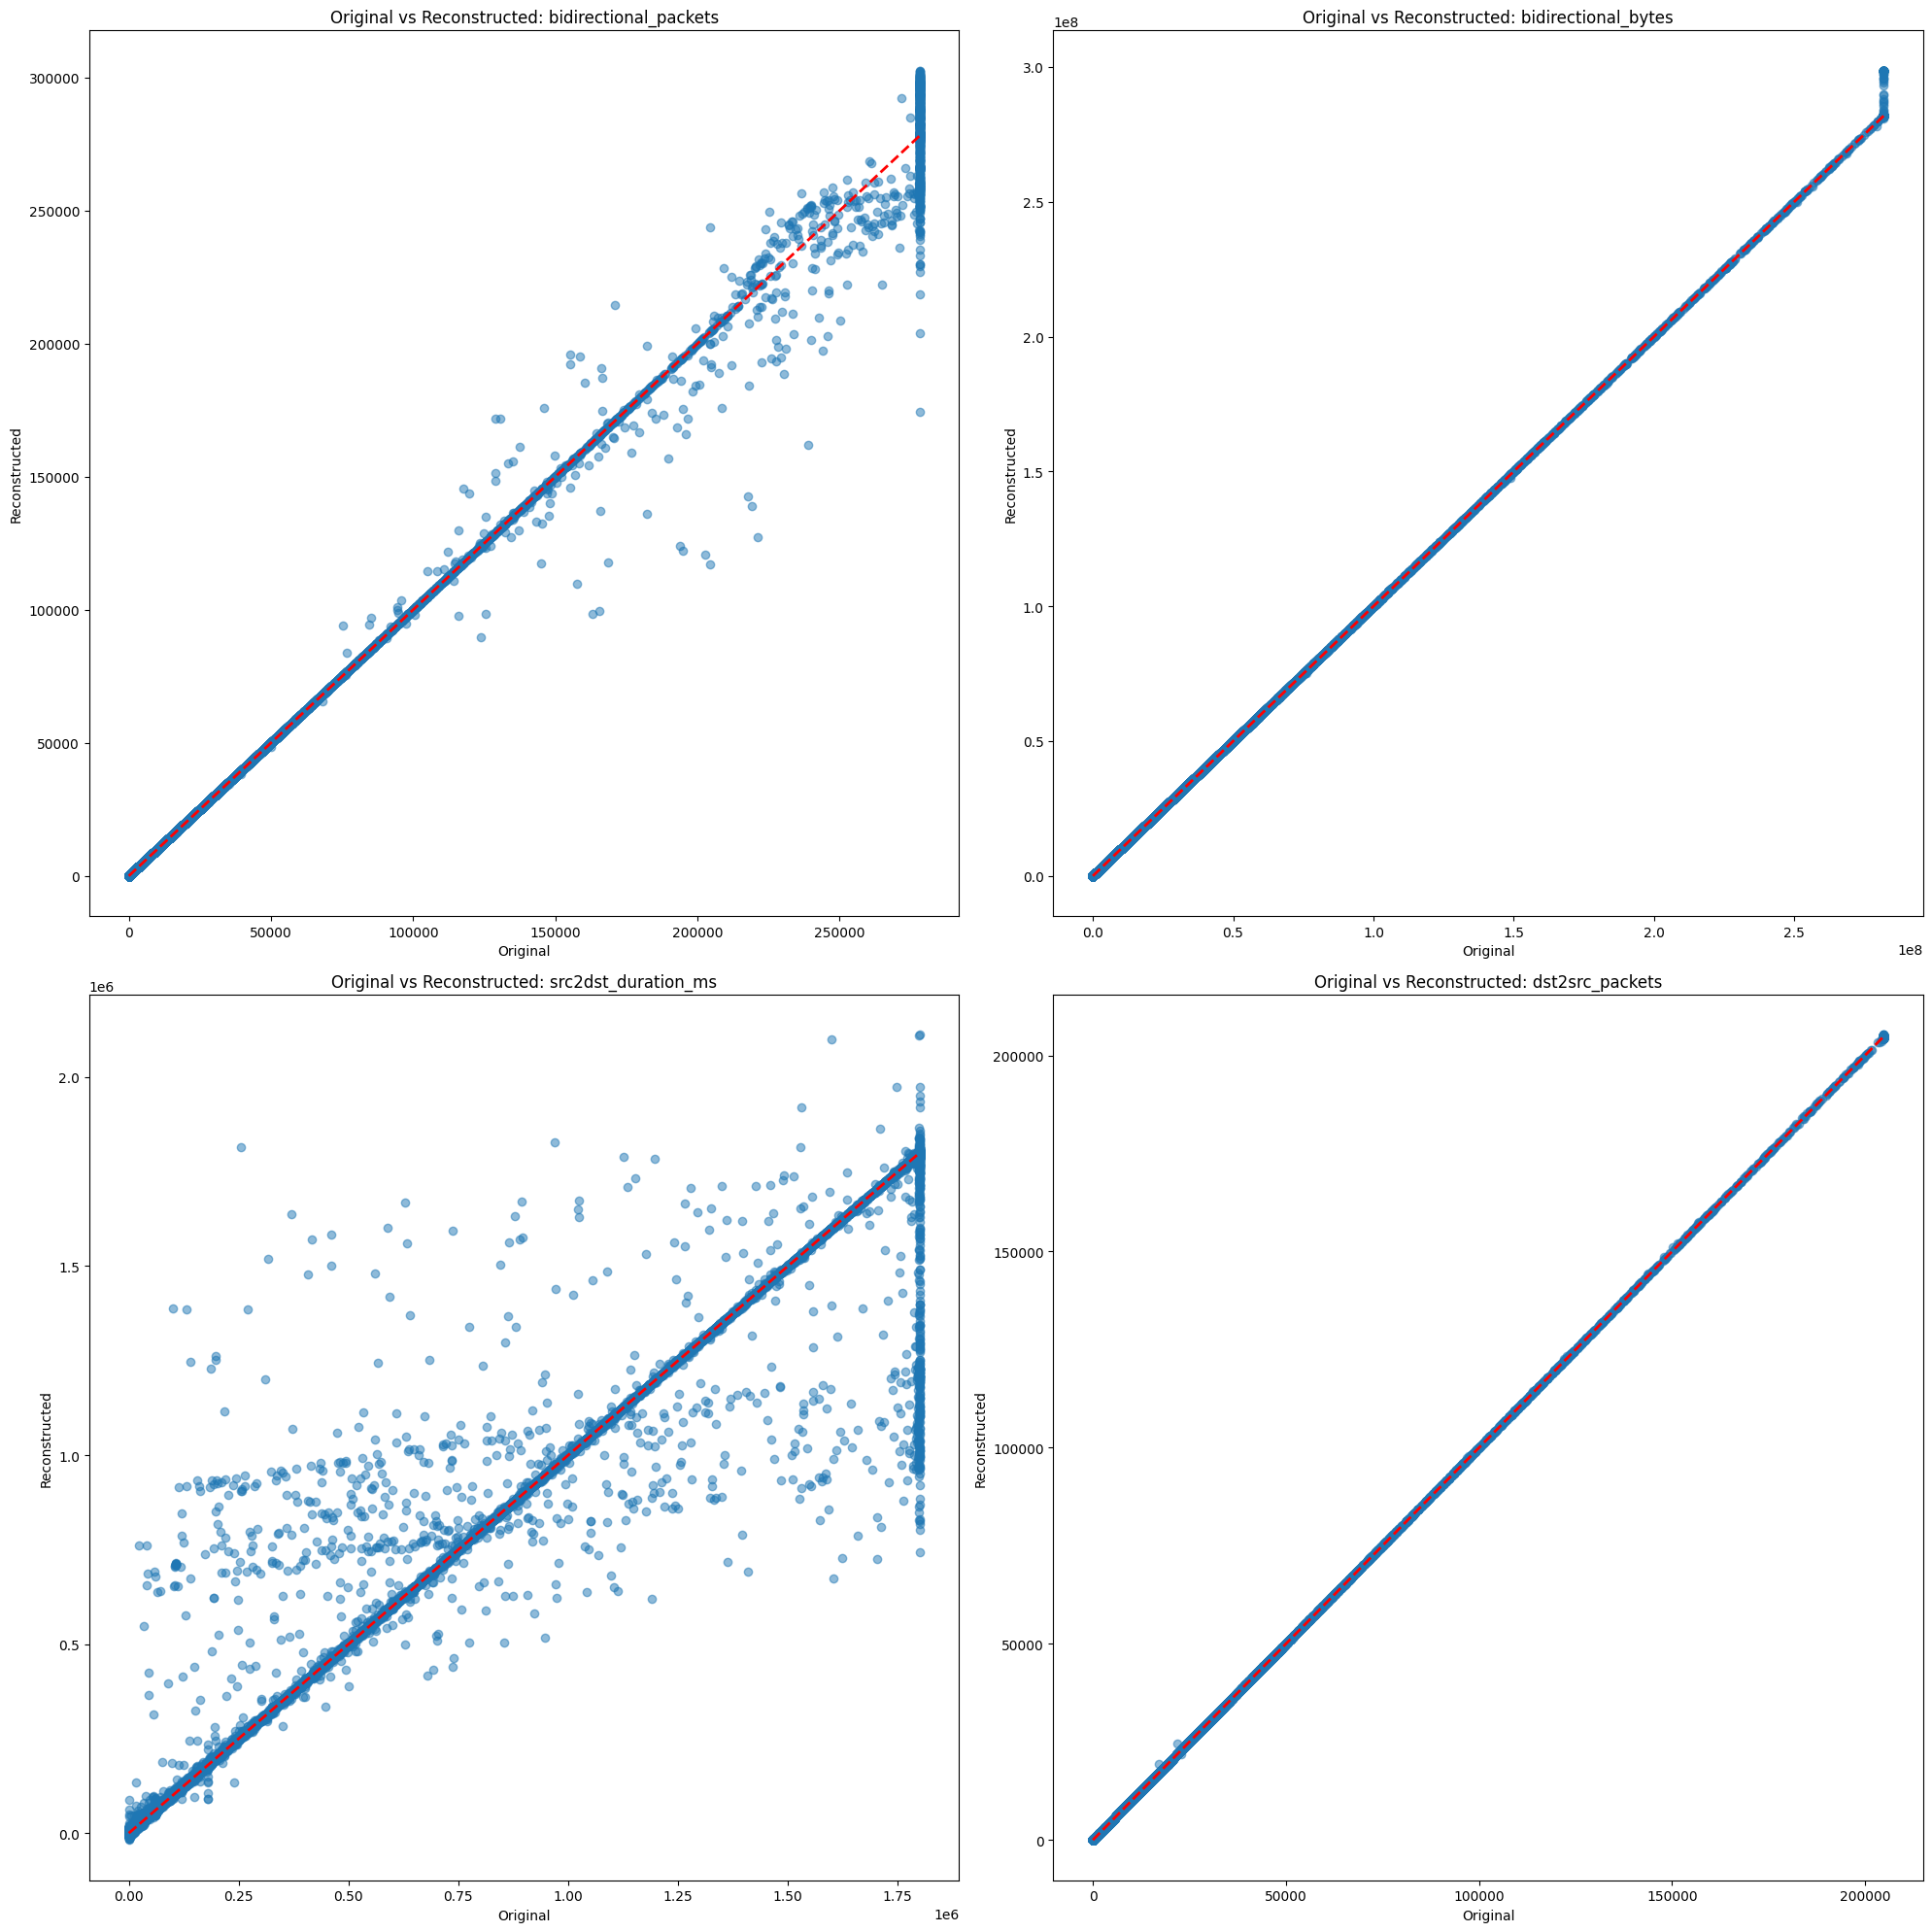

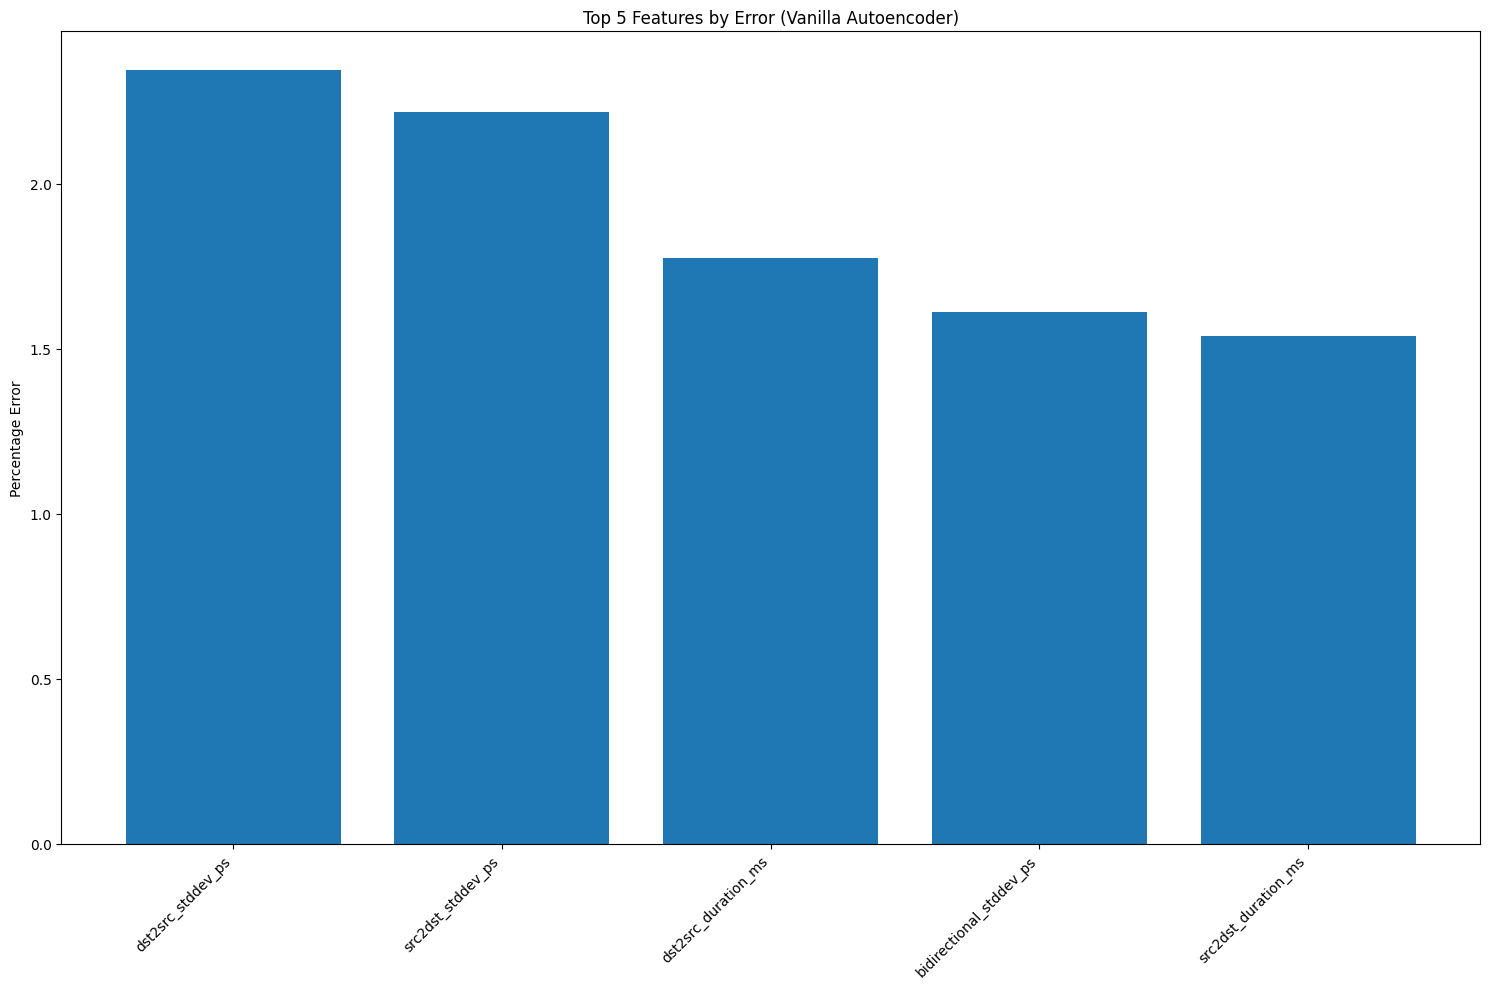

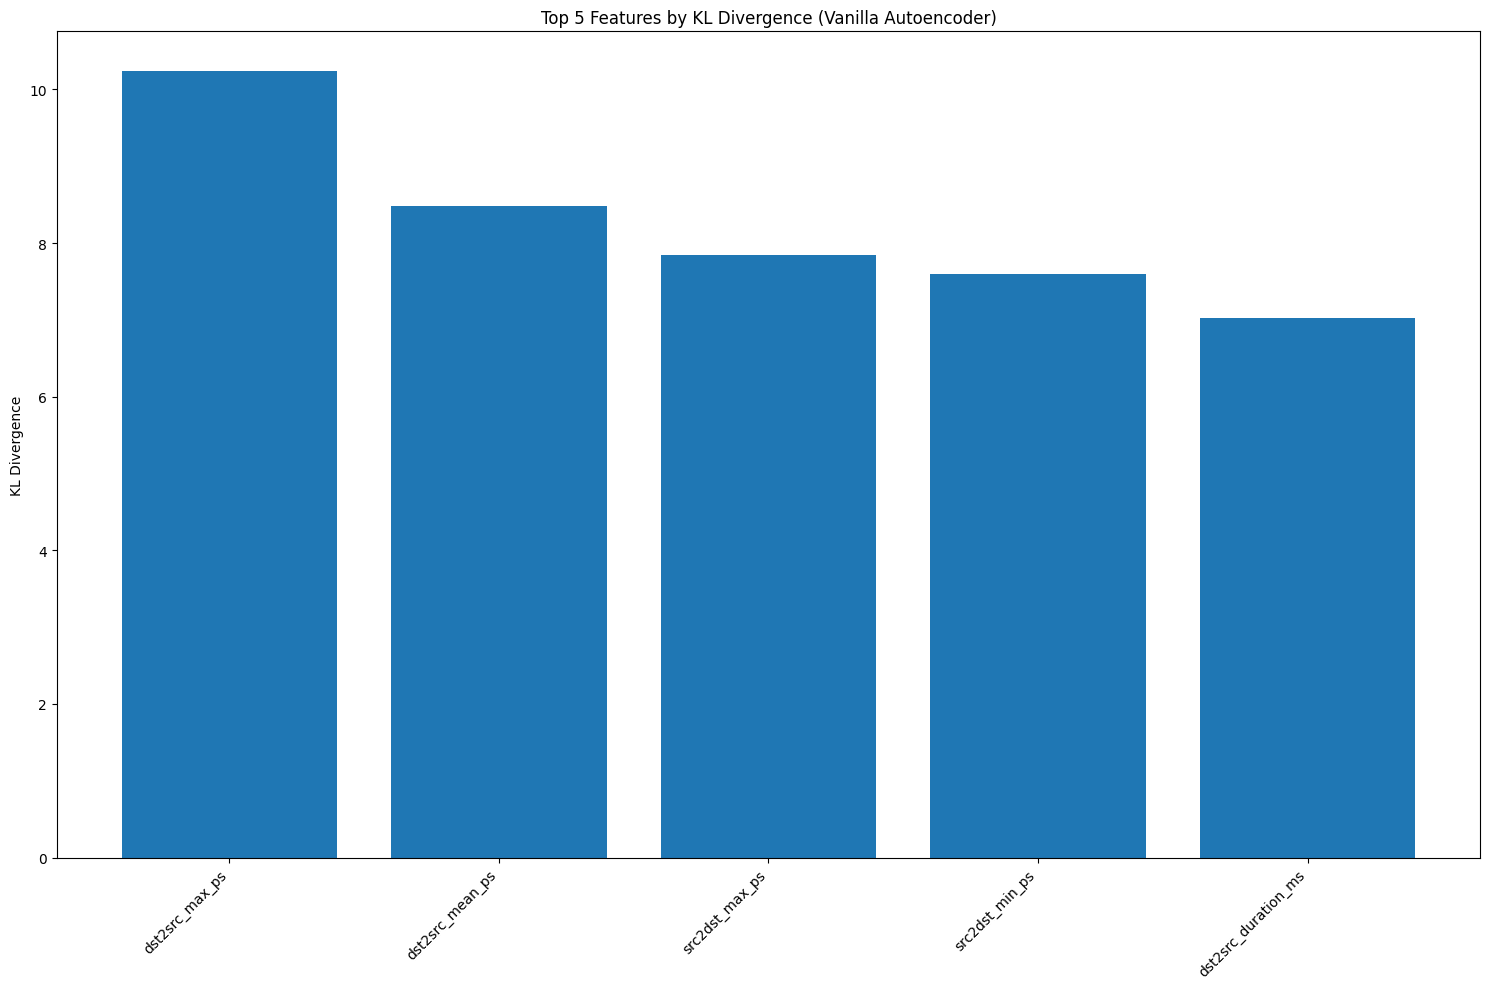

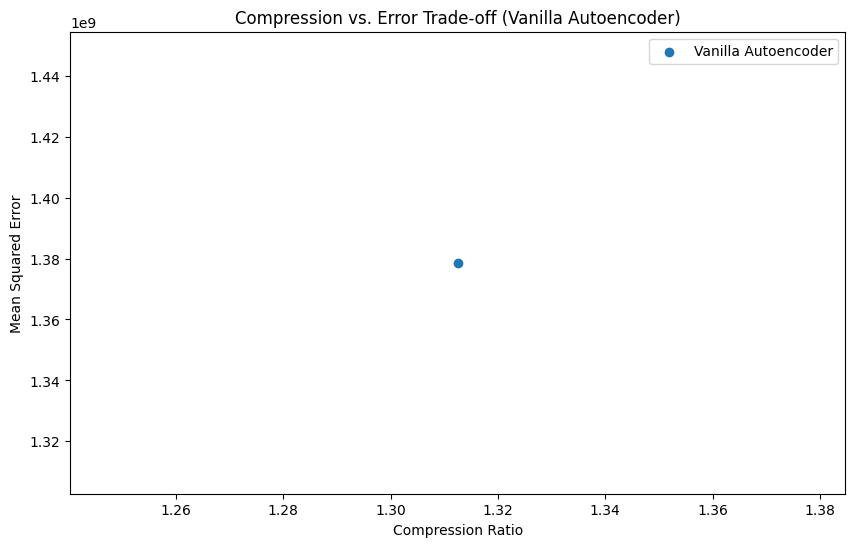

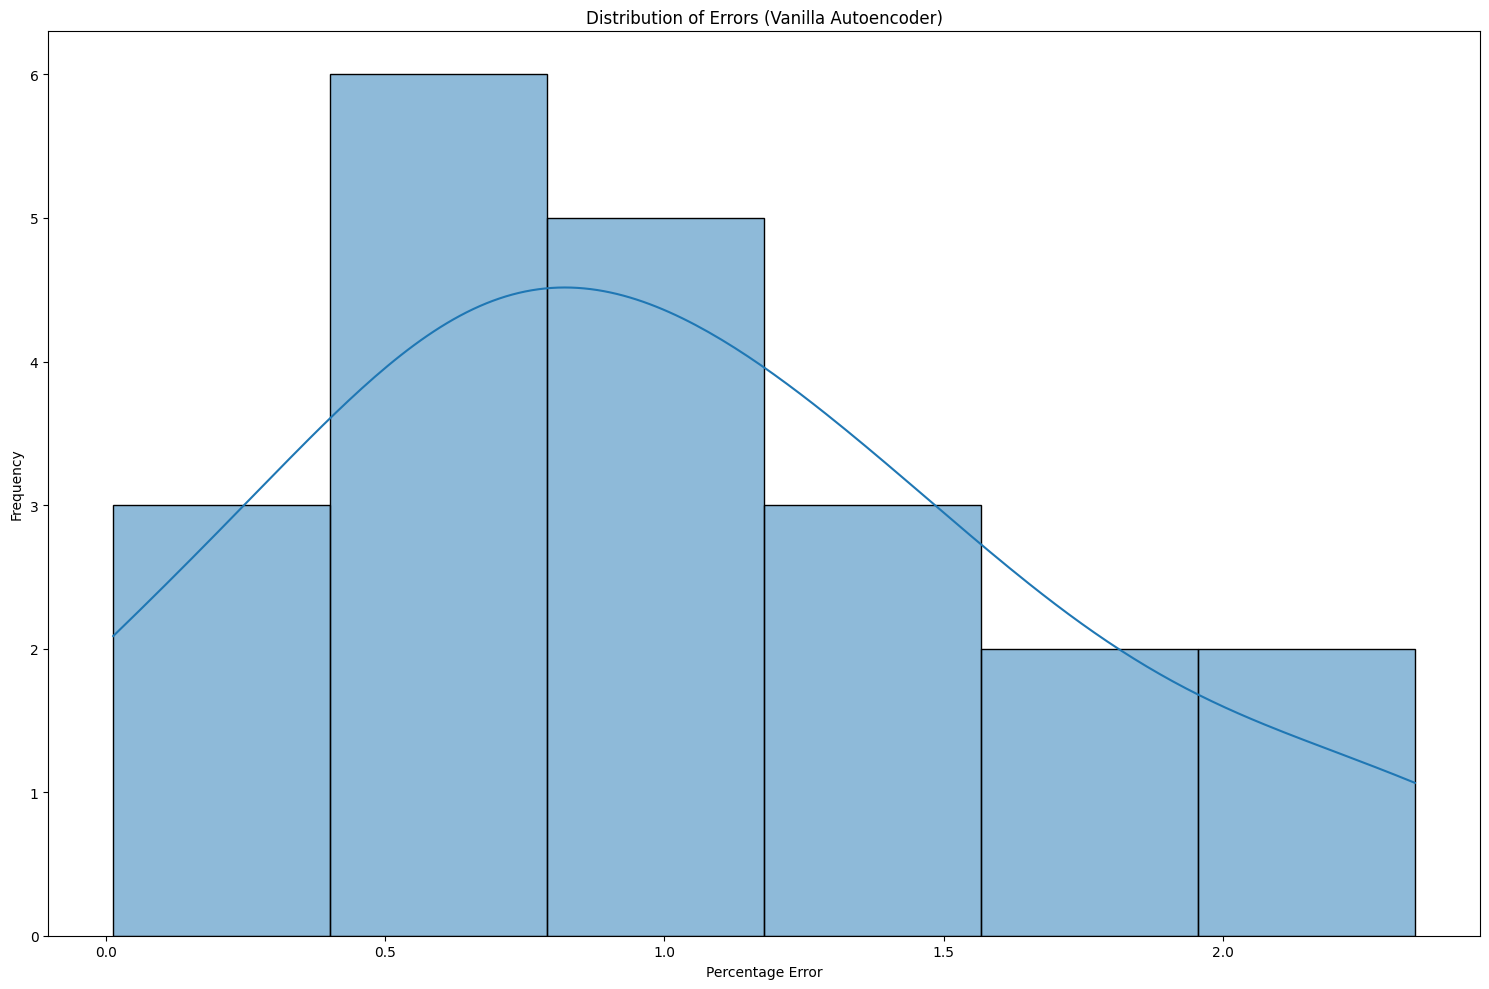

Visualization and analysis complete.


In [4]:
# Visualizations

# 1. Training and Test Loss
plt.figure(figsize=(10, 6))
plt.plot(results['vanilla']['train_losses'], label='Train Loss')
plt.plot(results['vanilla']['test_losses'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Vanilla Autoencoder: Training and Test Loss')
plt.legend()
plt.savefig('vanilla_autoencoder_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Comparison of performance metrics
metrics = ['mse', 'rmse', 'mape', 'compression_ratio']
comparison_data = {metric: [results['vanilla'][metric]] for metric in metrics}
comparison_df = pd.DataFrame(comparison_data, index=['vanilla'])

plt.figure(figsize=(12, 8))
comparison_df.plot(kind='bar')
plt.title('Vanilla Autoencoder Performance')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Feature-specific error comparisons
feature_errors_df = pd.DataFrame(results['vanilla']['feature_errors'], index=[0]).transpose()
plt.figure(figsize=(15, 10))
sns.heatmap(feature_errors_df, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Feature-specific Percentage Errors for Vanilla Autoencoder')
plt.ylabel('Features')
plt.xlabel('Vanilla Autoencoder')
plt.tight_layout()
plt.savefig('feature_errors_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# KL divergence comparisons
kl_divergences_df = pd.DataFrame(results['vanilla']['kl_divergences'], index=[0]).transpose()
plt.figure(figsize=(15, 10))
sns.heatmap(kl_divergences_df, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('KL Divergences for Vanilla Autoencoder')
plt.ylabel('Features')
plt.xlabel('Vanilla Autoencoder')
plt.tight_layout()
plt.savefig('kl_divergences_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation heatmaps
def calculate_correlation_matrix(data):
    return np.corrcoef(data.T)

# model = results['vanilla']['model']
# model.eval()
# with torch.no_grad():
#     reconstructed_data = model(X_test_tensor).cpu().numpy()

# # Inverse transform the data
# reconstructed_data = scaler.inverse_transform(reconstructed_data)
# X_test_original = scaler.inverse_transform(X_test)

# Calculate correlation matrices
original_corr = calculate_correlation_matrix(X_test_original)
reconstructed_corr = calculate_correlation_matrix(reconstructed_data)
diff_corr = original_corr - reconstructed_corr

# Plot correlation difference heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(diff_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            xticklabels=compressible_features, yticklabels=compressible_features, annot_kws={"size": 12})
# plt.title('Correlation Difference: Original - Reconstructed (Vanilla Autoencoder)')
# Set axis labels with increased font size
# plt.xlabel('Features', fontsize=18)
# plt.ylabel('Features', fontsize=18)
# Set tick labels with increased font size
plt.xticks(ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('correlation_difference.png', dpi=300, bbox_inches='tight')
plt.show()

# Original vs Reconstructed Scatter Plots
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
sample_features = ['bidirectional_packets', 'bidirectional_bytes', 'src2dst_duration_ms', 'dst2src_packets']
for i, feature in enumerate(sample_features):
    ax = axes[i // 2, i % 2]
    feature_index = compressible_features.index(feature)
    ax.scatter(X_test_original[:, feature_index], reconstructed_data[:, feature_index], alpha=0.5)
    ax.plot([X_test_original[:, feature_index].min(), X_test_original[:, feature_index].max()], 
            [X_test_original[:, feature_index].min(), X_test_original[:, feature_index].max()], 
            'r--', lw=2)
    ax.set_xlabel('Original')
    ax.set_ylabel('Reconstructed')
    ax.set_title(f'Original vs Reconstructed: {feature}')
plt.tight_layout()
plt.savefig('scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# Comparison of top features by importance (based on error and KL divergence)
def get_top_features(data, n=5):
    return sorted(data.items(), key=lambda x: x[1], reverse=True)[:n]

plt.figure(figsize=(15, 10))
top_errors = get_top_features(results['vanilla']['feature_errors'])
features, errors = zip(*top_errors)
plt.bar(features, errors)
plt.title('Top 5 Features by Error (Vanilla Autoencoder)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage Error')
plt.tight_layout()
plt.savefig('top_features_by_error.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(15, 10))
top_kl = get_top_features(results['vanilla']['kl_divergences'])
features, kl_divs = zip(*top_kl)
plt.bar(features, kl_divs)
plt.title('Top 5 Features by KL Divergence (Vanilla Autoencoder)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('KL Divergence')
plt.tight_layout()
plt.savefig('top_features_by_kl.png', dpi=300, bbox_inches='tight')
plt.show()

# Comparison of compression vs. error trade-off
plt.figure(figsize=(10, 6))
plt.scatter(results['vanilla']['compression_ratio'], results['vanilla']['mse'], label='Vanilla Autoencoder')
plt.xlabel('Compression Ratio')
plt.ylabel('Mean Squared Error')
plt.title('Compression vs. Error Trade-off (Vanilla Autoencoder)')
plt.legend()
plt.savefig('compression_vs_error.png', dpi=300, bbox_inches='tight')
plt.show()

# Distribution of errors across features
plt.figure(figsize=(15, 10))
errors = list(results['vanilla']['feature_errors'].values())
sns.histplot(errors, kde=True)
plt.title('Distribution of Errors (Vanilla Autoencoder)')
plt.xlabel('Percentage Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('distribution_of_errors.png', dpi=300, bbox_inches='tight')
plt.show()

# # Utility function to load the model (if needed later)
# def load_model(input_dim, encoding_dim):
#     model = BaseAutoencoder(input_dim, encoding_dim)
#     model.load_state_dict(torch.load('vanilla_model.pth'))
#     model.eval()
#     return model

# # Example of how to use the load_model function:
# loaded_vanilla_model = load_model(input_dim, encoding_dim)

print("Visualization and analysis complete.")

## Replot correlation difference with larger font

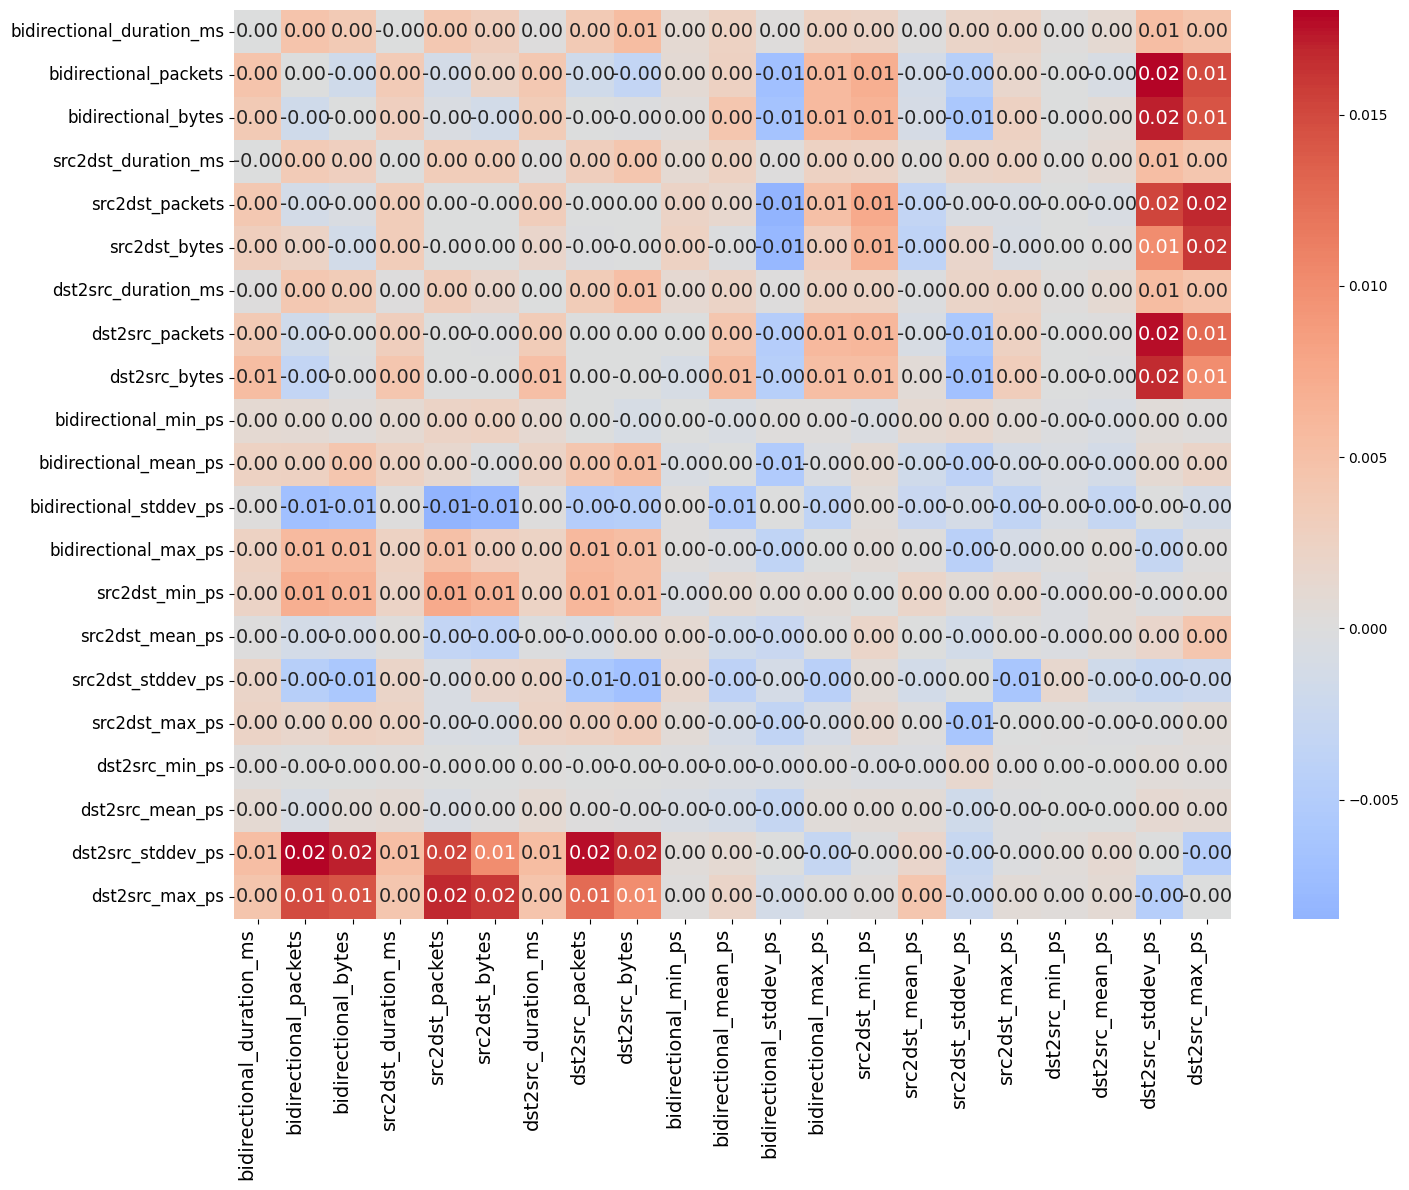

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot correlation difference heatmap with increased font sizes
plt.figure(figsize=(15, 12))

# Create the heatmap with larger annotation fonts
sns.heatmap(
    diff_corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    xticklabels=compressible_features,
    yticklabels=compressible_features,
    annot_kws={"size": 14}  # Increase annotation font size
)

# Add title with increased font size (optional)
# plt.title('Correlation Difference: Original - Reconstructed (Vanilla Autoencoder)', fontsize=18)

# Set axis labels with increased font size
# plt.xlabel('Features', fontsize=14)
# plt.ylabel('Features', fontsize=14)

# Set tick labels with increased font size
plt.xticks(ha='right', fontsize=14)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig('correlation_difference.png', dpi=300, bbox_inches='tight')
plt.show()


## Recalculate KL Divergences with the continuous form (above the discrete form was used)

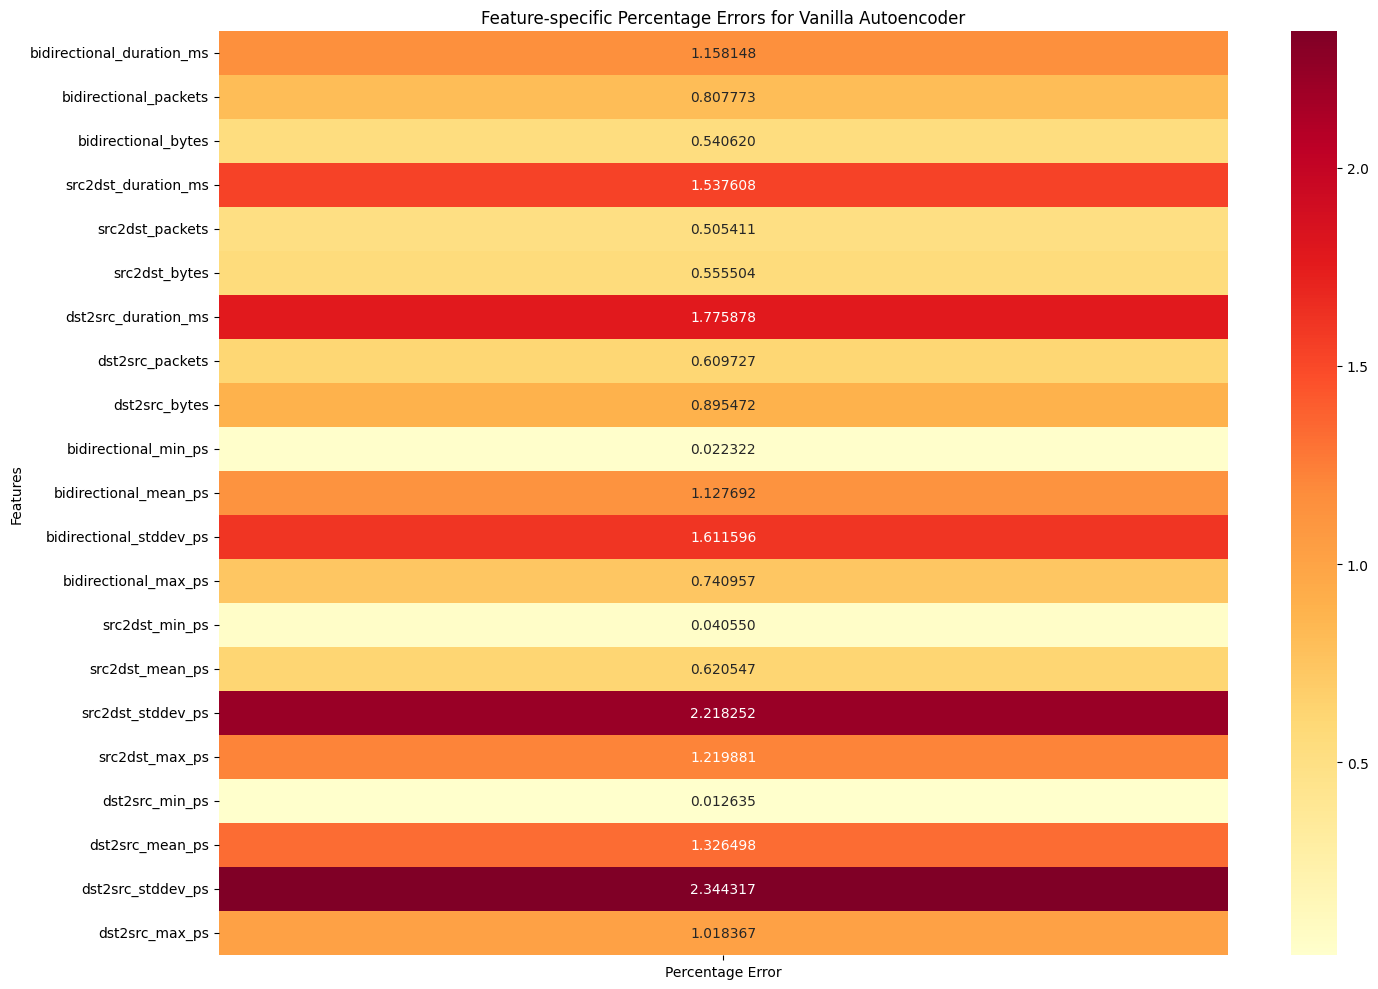

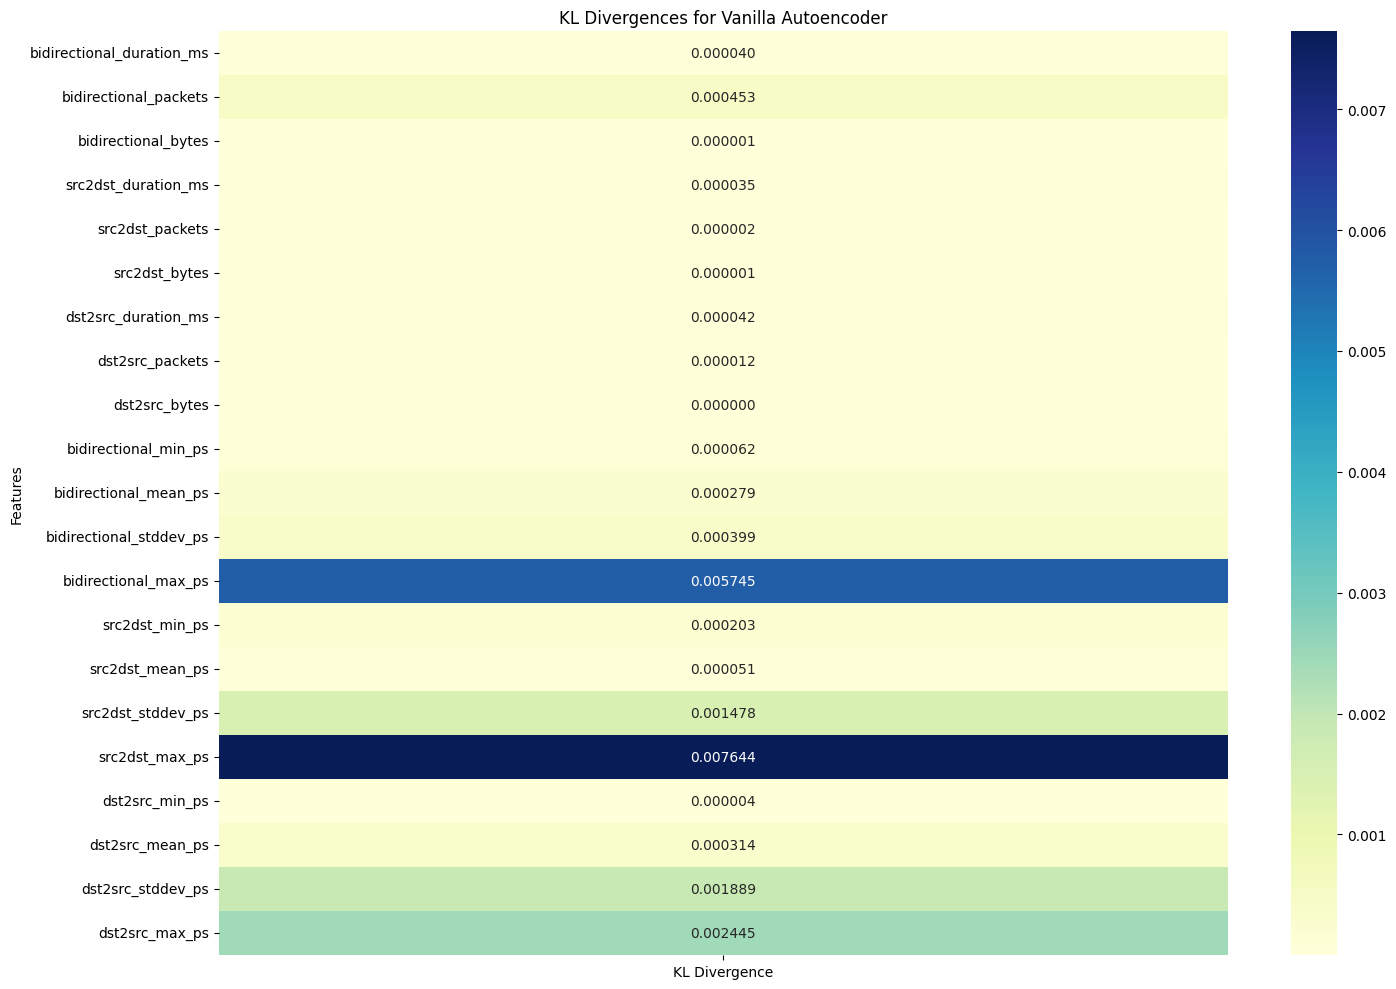

In [8]:
from scipy.stats import gaussian_kde
from scipy.integrate import simpson
import numpy as np

def compute_continuous_kl_divergence(original_data, reconstructed_data):
    """
    Computes KL divergence for continuous features using KDE and numerical integration.
    """
    # Estimate densities using Gaussian KDE
    kde_original = gaussian_kde(original_data)
    kde_reconstructed = gaussian_kde(reconstructed_data)
    
    # Define evaluation points for integration
    min_x = min(original_data.min(), reconstructed_data.min())
    max_x = max(original_data.max(), reconstructed_data.max())
    x_eval = np.linspace(min_x, max_x, 1000)  # Fine grid for integration
    
    # Evaluate densities
    p = kde_original(x_eval)
    q = kde_reconstructed(x_eval)
    
    # Add a small constant for numerical stability
    # epsilon = 1e-10
    epsilon = 1e-10 * np.max(p)
    p = p + epsilon
    q = q + epsilon
    
    # Normalize densities to ensure proper probability distributions
    p = p / simpson(p, x_eval)
    q = q / simpson(q, x_eval)
    
    # Compute KL divergence using numerical integration
    kl_div = simpson(p * np.log(p / q), x_eval)
    return max(0.0, kl_div)  # Ensure non-negative KL divergence

compressible_features = [
    'bidirectional_duration_ms', 'bidirectional_packets', 'bidirectional_bytes',
    'src2dst_duration_ms', 'src2dst_packets', 'src2dst_bytes',
    'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
    'bidirectional_min_ps', 'bidirectional_mean_ps', 'bidirectional_stddev_ps', 'bidirectional_max_ps',
    'src2dst_min_ps', 'src2dst_mean_ps', 'src2dst_stddev_ps', 'src2dst_max_ps',
    'dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps', 'dst2src_max_ps'
]

# Evaluate Reconstruction for X_test
model.eval()
with torch.no_grad():
    reconstructed_data = model(X_test_tensor).cpu().numpy()

# Inverse transform the data
reconstructed_data = scaler.inverse_transform(reconstructed_data)
X_test_original = scaler.inverse_transform(X_test)

# Ensure reconstructed_data is properly reshaped
reconstructed_data = reconstructed_data.reshape(-1, len(compressible_features))

feature_errors = {}
kl_divergences = {}
for i, feature in enumerate(compressible_features):
    percentage_error = np.median(np.abs((X_test_original[:, i] - reconstructed_data[:, i]) / (X_test_original[:, i] + 1e-8))) * 100
    # percentage_error = np.mean(np.abs((X_test_original[:, i] - reconstructed_data[:, i]) / (X_test_original[:, i] + 1e-8))) * 100
    feature_errors[feature] = float(percentage_error)
    
    try:
        # Extract feature-specific data
        original_data = X_test_original[:, i]
        reconstructed_data_col = reconstructed_data[:, i]

        # Print a sample of the data for debugging
        # print(f"Feature '{feature}' - Original sample: {original_data[:5]}")
        # print(f"Feature '{feature}' - Reconstructed sample: {reconstructed_data_col[:5]}")
        
        # Get observed bounds for the feature
        feature_min = original_data.min()
        feature_max = original_data.max()

        # print(f"{feature}: Min={feature_min}, Max={feature_max}")
        
        # Clip data to valid range
        original_data = np.clip(original_data, feature_min, feature_max)
        reconstructed_data_col = np.clip(reconstructed_data_col, feature_min, feature_max)

        # Define evaluation points within the valid range
        x_eval = np.linspace(feature_min, feature_max, 1000)

        # Compute continuous KL divergence
        kl_div = compute_continuous_kl_divergence(original_data, reconstructed_data_col)
        kl_divergences[feature] = kl_div
        # print(f"KL divergence for feature '{feature}': {kl_div:.6f}")

    except Exception as e:
        print(f"Error calculating KL divergence for feature '{feature}': {e}")
        kl_divergences[feature] = np.nan

# Create DataFrames for visualization
feature_errors_df = pd.DataFrame.from_dict(feature_errors, orient='index', columns=['Percentage Error'])
kl_divergences_df = pd.DataFrame.from_dict(kl_divergences, orient='index', columns=['KL Divergence']).fillna(0)

# Feature-specific error comparisons
# feature_errors_df = pd.DataFrame(results['vanilla']['feature_errors'], index=[0]).transpose()
plt.figure(figsize=(15, 10))
sns.heatmap(feature_errors_df, annot=True, fmt='.6f', cmap='YlOrRd')
plt.title('Feature-specific Percentage Errors for Vanilla Autoencoder')
plt.ylabel('Features')
# plt.xlabel('Percentage Error')
plt.tight_layout()
plt.savefig('feature_errors_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Convert to DataFrame, filling NaNs with a placeholder value (e.g., 0)
# kl_divergences_df = pd.DataFrame.from_dict(kl_divergences, orient='index', columns=['KL Divergence']).fillna(0)

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(kl_divergences_df, annot=True, fmt='.6f', cmap='YlGnBu')
plt.title('KL Divergences for Vanilla Autoencoder')
plt.ylabel('Features')
# plt.xlabel('KL Divergence')
plt.tight_layout()
plt.savefig('kl_divergences_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()  

In [17]:
# Combine the two datasets and reorder by percentage error
# feature_errors_df = pd.DataFrame.from_dict(feature_errors, orient='index', columns=['Percentage Error'])
# kl_divergences_df = pd.DataFrame.from_dict(kl_divergences, orient='index', columns=['KL Divergence']).fillna(0)

# Combine the metrics and sort by Percentage Error
combined_df = pd.concat([feature_errors_df, kl_divergences_df], axis=1)
combined_df = combined_df.sort_values('Percentage Error', ascending=False)

# Create separate sorted DataFrames for individual visualizations
# feature_errors_df_sorted = combined_df[['Percentage Error']]
# kl_divergences_df_sorted = combined_df[['KL Divergence']]

# # Feature-specific error comparisons
# plt.figure(figsize=(15, 10))
# sns.heatmap(feature_errors_df_sorted, annot=True, fmt='.6f', cmap='YlOrRd')
# plt.title('Feature-specific Percentage Errors for Vanilla Autoencoder (Sorted)')
# plt.ylabel('Features')
# plt.tight_layout()
# plt.savefig('feature_errors_heatmap.png', dpi=300, bbox_inches='tight')
# plt.show()

# Optional: Print the sorted values to verify they match the LaTeX table
print("\nSorted Feature Errors and KL Divergences:")
print(combined_df.to_string(float_format=lambda x: '{:.6f}'.format(x)))


Sorted Feature Errors and KL Divergences:
                           Percentage Error  KL Divergence
dst2src_stddev_ps                  2.344317       0.001889
src2dst_stddev_ps                  2.218252       0.001478
dst2src_duration_ms                1.775878       0.000042
bidirectional_stddev_ps            1.611596       0.000399
src2dst_duration_ms                1.537608       0.000035
dst2src_mean_ps                    1.326498       0.000314
src2dst_max_ps                     1.219881       0.007644
bidirectional_duration_ms          1.158148       0.000040
bidirectional_mean_ps              1.127692       0.000279
dst2src_max_ps                     1.018367       0.002445
dst2src_bytes                      0.895472       0.000000
bidirectional_packets              0.807773       0.000453
bidirectional_max_ps               0.740957       0.005745
src2dst_mean_ps                    0.620547       0.000051
dst2src_packets                    0.609727       0.000012
src2dst_bytes

## Compression comparison

## Compression (64→32)

In [9]:
import torch
import os
import tempfile
import zlib
import lzma
import numpy as np
import pandas as pd

def measure_model_size(model, temp_path='temp_model.pth'):
    """
    Save the model to disk and measure its size in bytes.
    Then remove the file to clean up.
    """
    torch.save(model.state_dict(), temp_path)
    size_bytes = os.path.getsize(temp_path)
    os.remove(temp_path)
    return size_bytes

def compare_compression_with_overhead(data, model=None, methods=None, files_count=1):
    """
    Produce two separate tables (DataFrames) comparing compression methods:
      1) In-Memory Compression: Shows memory footprint including model overhead
      2) On-Disk Compression: Shows disk footprint with various overhead metrics
    
    Parameters:
        data: NumPy array to compress
        model: Trained autoencoder model (required if 'autoencoder' in methods)
        methods: List of compression methods to compare
        files_count: Number of files for amortizing AE model overhead
    """
    if methods is None:
        methods = ['autoencoder', 'zip', 'lzma', 'parquet', 'h5']

    # Calculate original size
    original_size_bytes = data.nbytes
    original_size_mb = original_size_bytes / (1024 * 1024)

    # Initialize results containers
    in_mem_results = []
    disk_results = []

    # Convert data to bytes once for compression methods
    data_bytes = data.tobytes()

    for method in methods:
        # Initialize common variables
        model_size_mb = 0.0
        in_memory_encoded_size_mb = np.nan
        disk_encoded_size_mb = 0.0

        # Process each compression method
        if method == 'autoencoder':
            if model is None:
                raise ValueError("Trained model required for autoencoder method")

            # Calculate model size
            model_size_bytes = measure_model_size(model)
            model_size_mb = model_size_bytes / (1024 * 1024)

            # Get in-memory encoded representation
            encoded_data = model.encoder(torch.FloatTensor(data)).detach().numpy()
            in_memory_encoded_size_mb = encoded_data.nbytes / (1024 * 1024)

            # Get on-disk size
            encoded_data_bytes = encoded_data.tobytes()
            with tempfile.NamedTemporaryFile(delete=False) as f:
                f.write(encoded_data_bytes)
            disk_encoded_size_mb = os.path.getsize(f.name) / (1024 * 1024)
            os.unlink(f.name)

        elif method == 'zip':
            # Compress data in memory
            compressed_data = zlib.compress(data_bytes)
            in_memory_encoded_size_mb = len(compressed_data) / (1024 * 1024)
            
            # Write to disk to get disk size
            with tempfile.NamedTemporaryFile(delete=False) as f:
                f.write(compressed_data)
            disk_encoded_size_mb = os.path.getsize(f.name) / (1024 * 1024)
            os.unlink(f.name)

        elif method == 'lzma':
            # Compress data in memory
            compressed_data = lzma.compress(data_bytes)
            in_memory_encoded_size_mb = len(compressed_data) / (1024 * 1024)
            
            # Write to disk to get disk size
            with tempfile.NamedTemporaryFile(delete=False) as f:
                f.write(compressed_data)
            disk_encoded_size_mb = os.path.getsize(f.name) / (1024 * 1024)
            os.unlink(f.name)

        elif method == 'parquet':
            # Parquet is disk-only format
            df = pd.DataFrame(data)
            with tempfile.NamedTemporaryFile(delete=False, suffix='.parquet') as f:
                df.to_parquet(f.name)
            disk_encoded_size_mb = os.path.getsize(f.name) / (1024 * 1024)
            os.unlink(f.name)

        elif method == 'h5':
            # HDF5 is disk-only format
            df = pd.DataFrame(data)
            with tempfile.NamedTemporaryFile(delete=False, suffix='.h5') as f:
                df.to_hdf(f.name, key='df', mode='w')
            disk_encoded_size_mb = os.path.getsize(f.name) / (1024 * 1024)
            os.unlink(f.name)

        else:
            raise ValueError(f"Unknown compression method: {method}")

        # Add in-memory results if applicable (skip disk-only formats)
        if not np.isnan(in_memory_encoded_size_mb) and in_memory_encoded_size_mb > 0:
            total_in_memory_size_mb = in_memory_encoded_size_mb + model_size_mb
            in_mem_results.append({
                'method': method,
                'original_size_mb': original_size_mb,
                'in_memory_encoded_size_mb': in_memory_encoded_size_mb,
                'model_size_mb': model_size_mb,
                'encoded_size_including_model_mb': total_in_memory_size_mb,
                'compression_ratio_excl_overhead': original_size_mb / in_memory_encoded_size_mb,
                'compression_ratio_incl_overhead': original_size_mb / total_in_memory_size_mb
            })

        # Add disk results for all methods
        total_disk_size_mb = disk_encoded_size_mb + model_size_mb
        amortized_size_mb = disk_encoded_size_mb + (model_size_mb / files_count)
        
        disk_results.append({
            'method': method,
            'original_size_mb': original_size_mb,
            'encoded_size_mb': disk_encoded_size_mb,
            'model_size_mb': model_size_mb,
            'encoded_size_including_model_mb': total_disk_size_mb,
            'compression_ratio_excl_overhead': original_size_mb / disk_encoded_size_mb,
            'compression_ratio_incl_overhead': original_size_mb / total_disk_size_mb,
            'amortized_encoded_size_mb': amortized_size_mb,
            'amortized_compression_ratio': original_size_mb / amortized_size_mb
        })

    return pd.DataFrame(in_mem_results), pd.DataFrame(disk_results)

# ------------------------------------------------------------------------------
"""
# Suppose our code does something like:
#   X_scaled = ... (NumPy array)
#   X_train_tensor = torch.FloatTensor(X_train)  # train from train/test split
#   model = BaseAutoencoder(...)  # trained AE model
"""

methods = ['autoencoder','zip','lzma','parquet','h5']
in_mem_df, disk_df = compare_compression_with_overhead(
    data=X_train,
    model=model,
    methods=methods,
    files_count=1000  # e.g., if we compress k different files with same AE
)

# print("IN-MEMORY RESULTS (AE / ZIP / LZMA):")
# print(in_mem_df.round(3))
# in_mem_df
# print("\nON-DISK RESULTS (AE / ZIP / LZMA / Parquet / HDF5):")
# print(disk_df.round(3))
# disk_df

In [10]:
in_mem_df

,method,original_size_mb,in_memory_encoded_size_mb,model_size_mb,encoded_size_including_model_mb,compression_ratio_excl_overhead,compression_ratio_incl_overhead
0,autoencoder,405.472939,154.465881,0.096712,154.562593,2.625000,2.623357
1,zip,405.472939,251.560006,0.000000,251.560006,1.611834,1.611834
2,lzma,405.472939,129.653309,0.000000,129.653309,3.127363,3.127363


## Compression (32→32)

In [11]:

# ------------------------------------------------------------------------------
"""
# Suppose our code does something like:
#   X_scaled = ... (NumPy array)
#   X_train_tensor = torch.FloatTensor(X_train)  # train from train/test split
#   model = BaseAutoencoder(...)  # trained AE model
"""

methods = ['autoencoder','zip','lzma','parquet','h5']
in_mem_df, disk_df = compare_compression_with_overhead(
    data=X_train.astype(np.float32), # Use training data only, in float32
    model=model,
    methods=methods,
    files_count=1000  # e.g., if we compress k different files with same AE
)

# print("IN-MEMORY RESULTS (AE / ZIP / LZMA):")
# print(in_mem_df.round(3))
# in_mem_df
# print("\nON-DISK RESULTS (AE / ZIP / LZMA / Parquet / HDF5):")
# print(disk_df.round(3))
# disk_df

In [12]:
in_mem_df

,method,original_size_mb,in_memory_encoded_size_mb,model_size_mb,encoded_size_including_model_mb,compression_ratio_excl_overhead,compression_ratio_incl_overhead
0,autoencoder,202.736469,154.465881,0.096712,154.562593,1.312500,1.311679
1,zip,202.736469,135.313638,0.000000,135.313638,1.498271,1.498271
2,lzma,202.736469,83.518124,0.000000,83.518124,2.427455,2.427455


## Classification


Classification Report - Original Features:
                precision    recall  f1-score   support

    BitTorrent       1.00      1.00      1.00     68848
       Discord       1.00      1.00      1.00     33217
          HTTP       1.00      1.00      1.00     60675
QUIC.Instagram       1.00      1.00      1.00     26645
  QUIC.YouTube       1.00      1.00      1.00    130105
           RDP       1.00      1.00      1.00     21566
          STUN       1.00      1.00      1.00     31009
  TLS.Facebook       0.99      0.99      0.99     64216
    TLS.TikTok       1.00      1.00      1.00    181713
      WhatsApp       1.00      0.99      0.99     14699

      accuracy                           1.00    632693
     macro avg       1.00      1.00      1.00    632693
  weighted avg       1.00      1.00      1.00    632693

Accuracy - Original Features: 0.9977

Classification Report - Vanilla AE Compressed Features:
                precision    recall  f1-score   support

    BitTorrent    

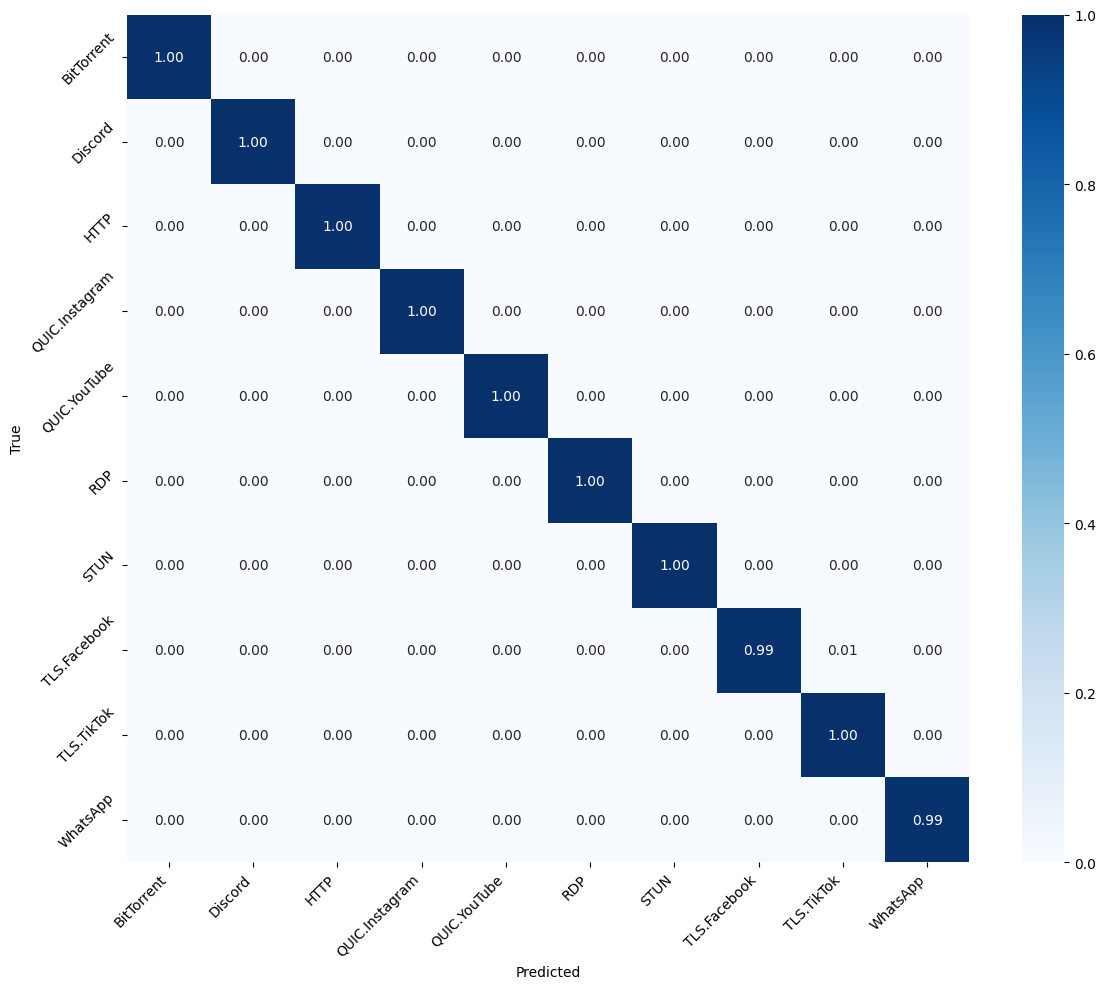

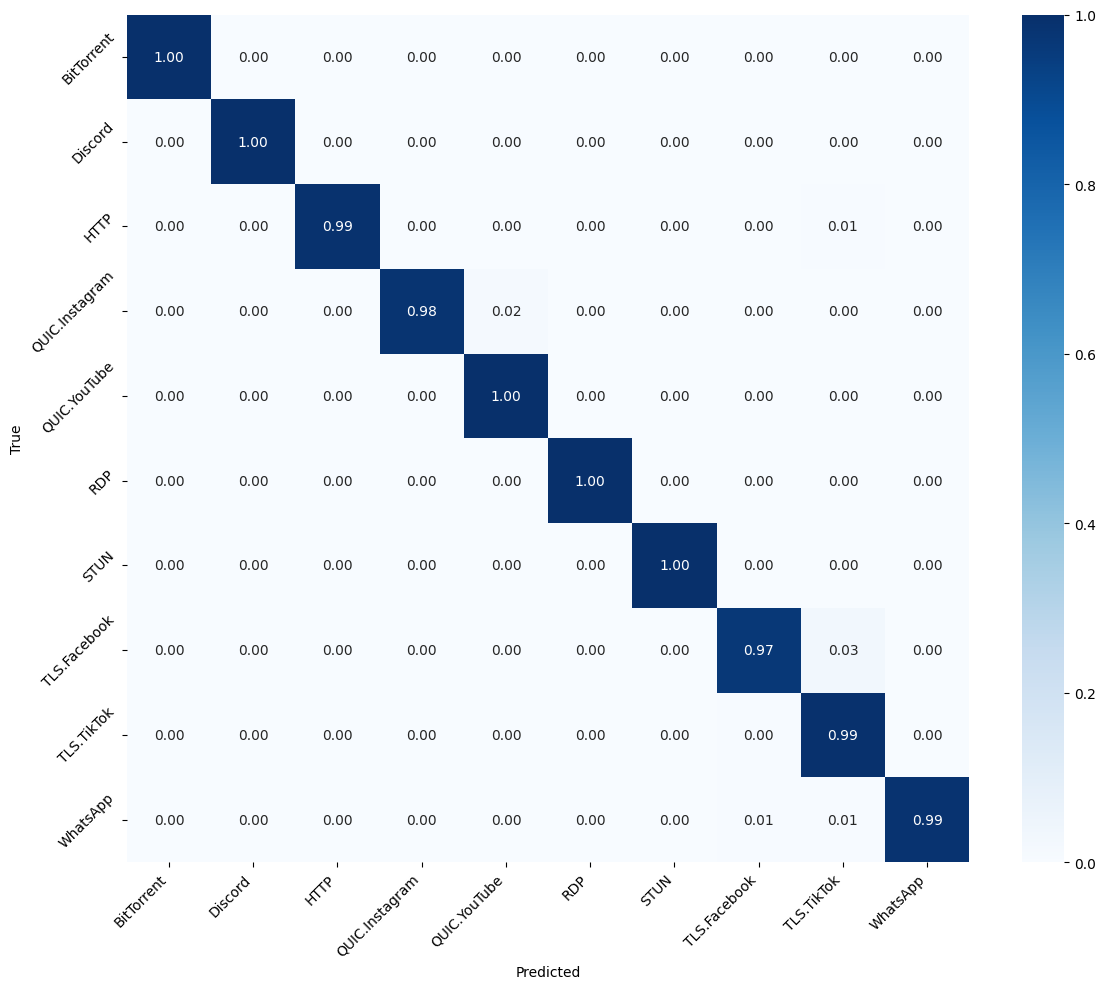

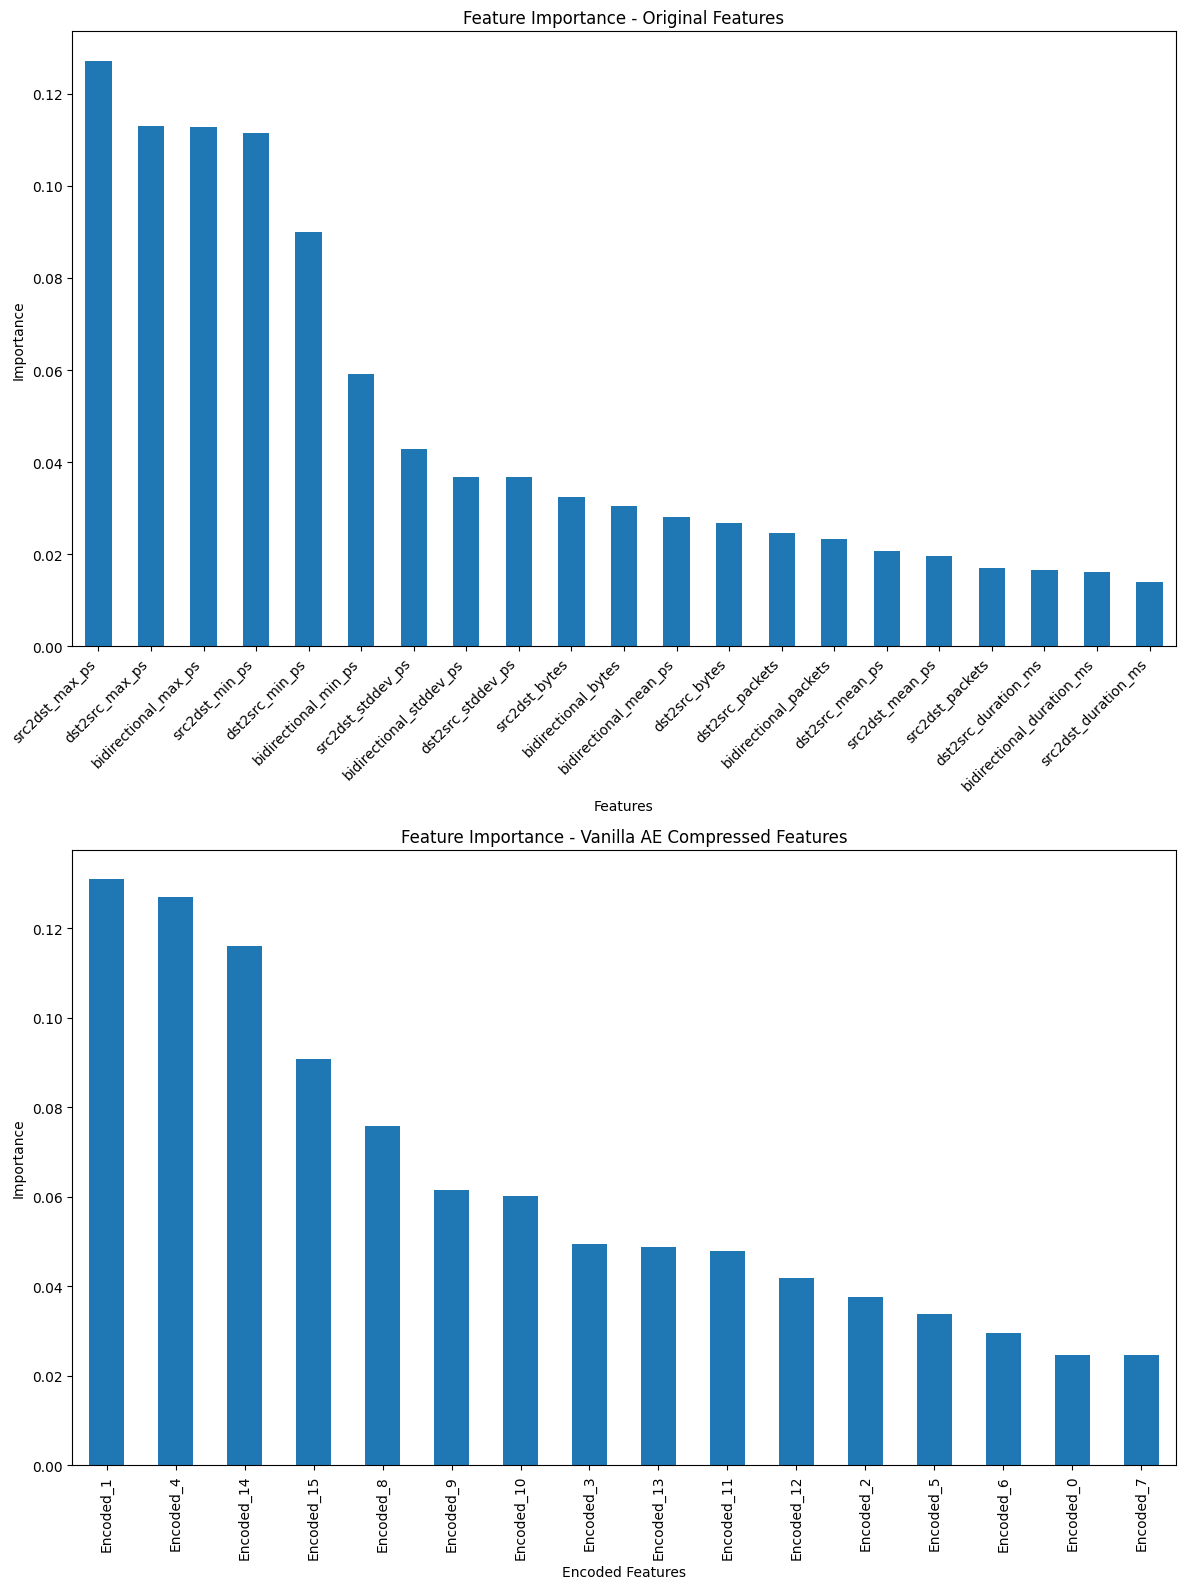

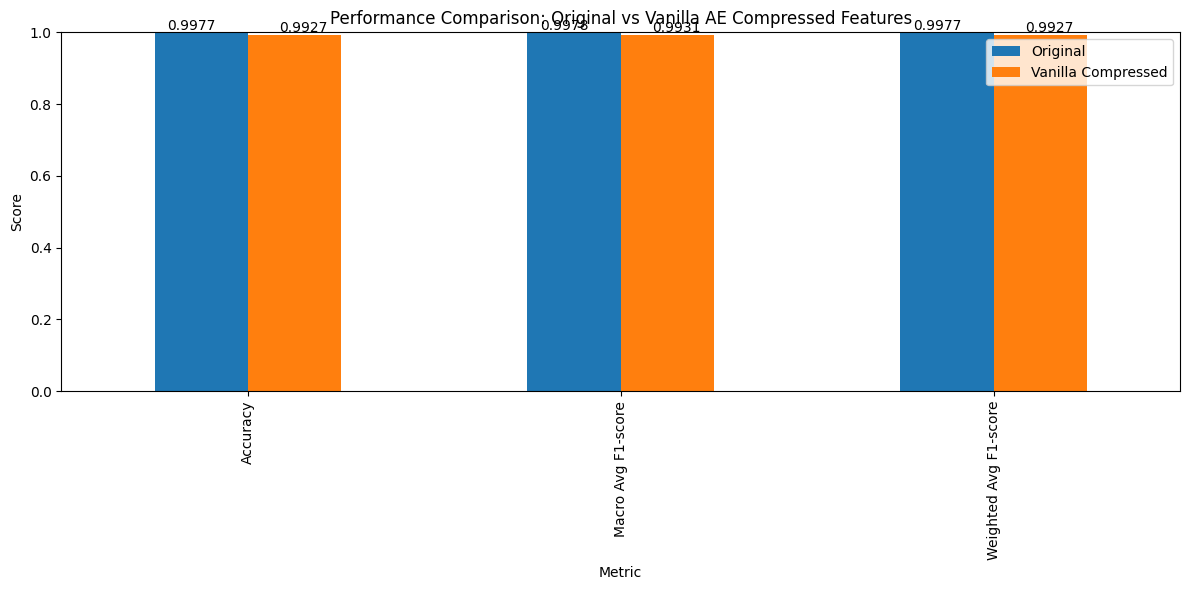

In [13]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load the autoencoder models and related data
def load_autoencoder(model_path, input_dim, encoding_dim):
    class Autoencoder(torch.nn.Module):
        def __init__(self, input_dim, encoding_dim):
            super(Autoencoder, self).__init__()
            self.encoder = torch.nn.Sequential(
                torch.nn.Linear(input_dim, 128),
                torch.nn.LeakyReLU(0.2),
                torch.nn.Linear(128, 64),
                torch.nn.LeakyReLU(0.2),
                torch.nn.Linear(64, encoding_dim),
                torch.nn.LeakyReLU(0.2)
            )
            self.decoder = torch.nn.Sequential(
                torch.nn.Linear(encoding_dim, 64),
                torch.nn.LeakyReLU(0.2),
                torch.nn.Linear(64, 128),
                torch.nn.LeakyReLU(0.2),
                torch.nn.Linear(128, input_dim)
            )
        
        def forward(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

    model = Autoencoder(input_dim, encoding_dim)
    model.load_state_dict(torch.load(model_path, weights_only=False))
    model.eval()
    return model

# Load models
with open('feature_names.json', 'r') as f:
    compressible_features = json.load(f)

input_dim = len(compressible_features)
encoding_dim = 16  # This must match what we used in training

vanilla_model = load_autoencoder('vanilla_model.pth', input_dim, encoding_dim)

# Load the scaler
scaler = joblib.load('robust_scaler.joblib')

# Load and preprocess the data
df = pd.read_parquet('dataset.parquet')
X = df[compressible_features].copy()
y = df['application_name']

# Remove extreme outliers (values beyond 99.9th percentile)
for column in X.columns:
    threshold = X[column].quantile(0.999)
    X.loc[:, column] = X[column].clip(upper=threshold).astype(X[column].dtype)

# Scale the features
X_scaled = scaler.transform(X)

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Generate compressed features
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)

with torch.no_grad():
    X_train_compressed_vanilla = vanilla_model.encoder(X_train_tensor).numpy()
    X_test_compressed_vanilla = vanilla_model.encoder(X_test_tensor).numpy()

# Function to train and evaluate Random Forest
def evaluate_rf(X_train, X_test, y_train, y_test, feature_type):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    print(f"\nClassification Report - {feature_type} Features:")
    report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print(f"Accuracy - {feature_type} Features: {accuracy_score(y_test, y_pred):.4f}")
    
    return rf, y_pred, report

# Evaluate models
rf_original, y_pred_original, original_report = evaluate_rf(X_train, X_test, y_train, y_test, "Original")
rf_vanilla, y_pred_vanilla, vanilla_report = evaluate_rf(X_train_compressed_vanilla, X_test_compressed_vanilla, y_train, y_test, "Vanilla AE Compressed")

# Prepare results for storage
results = {
    "original_features": {
        "classification_report": original_report,
        "accuracy": float(accuracy_score(y_test, y_pred_original))
    },
    "vanilla_compressed_features": {
        "classification_report": vanilla_report,
        "accuracy": float(accuracy_score(y_test, y_pred_vanilla))
    },
    "misclassification_analysis": {
        "original_misclassifications": int(np.sum(y_test != y_pred_original)),
        "vanilla_compressed_misclassifications": int(np.sum(y_test != y_pred_vanilla)),
        "common_misclassifications": int(np.sum((y_test != y_pred_original) & (y_test != y_pred_vanilla)))
    },
    "top_misclassified_classes": {
        "original": {k: int(v) for k, v in pd.Series(le.inverse_transform(y_test[y_test != y_pred_original])).value_counts().head().items()},
        "vanilla_compressed": {k: int(v) for k, v in pd.Series(le.inverse_transform(y_test[y_test != y_pred_vanilla])).value_counts().head().items()}
    },
    "normalized_confusion_matrices": {
        "original": confusion_matrix(y_test, y_pred_original, normalize='true').tolist(),
        "vanilla_compressed": confusion_matrix(y_test, y_pred_vanilla, normalize='true').tolist()
    }
}

# Save results to JSON
with open('classification_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("\nResults have been saved to 'classification_results.json'")

# Print overall comparison
performance_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro Avg F1-score', 'Weighted Avg F1-score'],
    'Original': [
        results['original_features']['accuracy'],
        results['original_features']['classification_report']['macro avg']['f1-score'],
        results['original_features']['classification_report']['weighted avg']['f1-score']
    ],
    'Vanilla Compressed': [
        results['vanilla_compressed_features']['accuracy'],
        results['vanilla_compressed_features']['classification_report']['macro avg']['f1-score'],
        results['vanilla_compressed_features']['classification_report']['weighted avg']['f1-score']
    ]
})
performance_comparison.set_index('Metric', inplace=True)
print("\nOverall Comparison:")
print(performance_comparison)

# Print misclassification analysis
print("\nMisclassification Analysis:")
print(f"Total misclassifications - Original: {results['misclassification_analysis']['original_misclassifications']}")
print(f"Total misclassifications - Vanilla Compressed: {results['misclassification_analysis']['vanilla_compressed_misclassifications']}")
print(f"Common misclassifications: {results['misclassification_analysis']['common_misclassifications']}")

print("\nTop 5 most misclassified classes:")
for feature_type in ['original', 'vanilla_compressed']:
    print(f"\n{feature_type.capitalize()} Features:")
    for class_name, count in results['top_misclassified_classes'][feature_type].items():
        print(f"{class_name}: {count}")

# Visualizations
def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=1)
    # plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{title}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 1. Confusion Matrices
# for feature_type in ['original', 'vanilla_compressed']:
#     plot_confusion_matrix(np.array(results['confusion_matrices'][feature_type]), le.classes_, f'Confusion Matrix - {feature_type.capitalize()} Features')

# Plot normalized confusion matrices
for feature_type in ['original', 'vanilla_compressed']:
    plot_confusion_matrix(np.array(results['normalized_confusion_matrices'][feature_type]), 
                          le.classes_, 
                          f'Normalized Confusion Matrix - {feature_type.capitalize()} Features')

# 2. Feature Importance Comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

feature_importance_original = pd.Series(rf_original.feature_importances_, index=compressible_features)
feature_importance_original.sort_values(ascending=False).plot(kind='bar', ax=ax1)
ax1.set_title('Feature Importance - Original Features')
ax1.set_xlabel('Features')
ax1.set_ylabel('Importance')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

feature_importance_vanilla = pd.Series(rf_vanilla.feature_importances_, index=[f'Encoded_{i}' for i in range(encoding_dim)])
feature_importance_vanilla.sort_values(ascending=False).plot(kind='bar', ax=ax2)
ax2.set_title('Feature Importance - Vanilla AE Compressed Features')
ax2.set_xlabel('Encoded Features')
ax2.set_ylabel('Importance')

plt.tight_layout()
plt.show()

# 3. Performance Comparison
fig, ax = plt.subplots(figsize=(12, 6))
performance_comparison.plot(kind='bar', ax=ax)
plt.title('Performance Comparison: Original vs Vanilla AE Compressed Features')
plt.ylabel('Score')
plt.ylim(0, 1)
for i, (index, row) in enumerate(performance_comparison.iterrows()):
    plt.text(i-0.15, row['Original'], f"{row['Original']:.4f}", ha='center', va='bottom')
    plt.text(i+0.15, row['Vanilla Compressed'], f"{row['Vanilla Compressed']:.4f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

## Replot confusion matrices with larger font

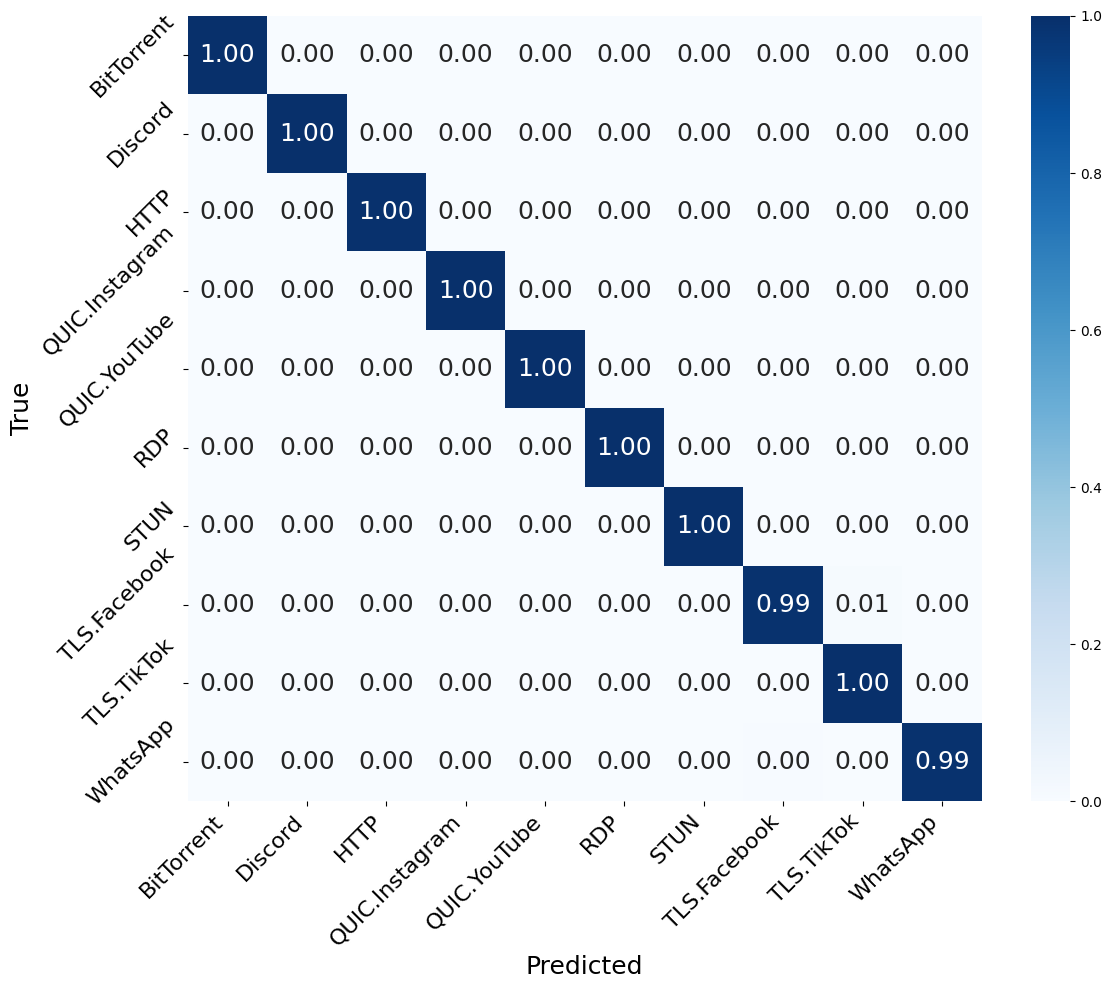

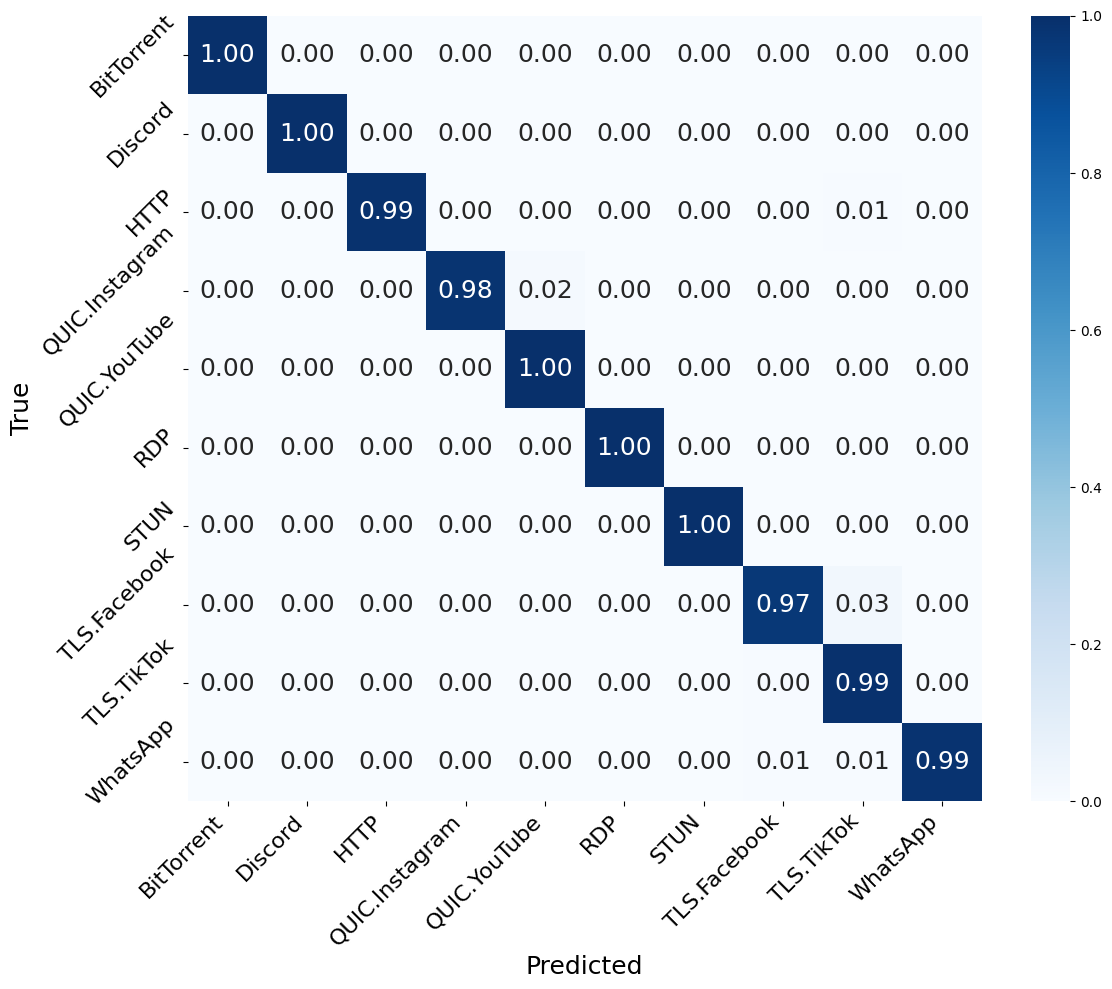

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualizations
def plot_confusion_matrix(cm, class_names, title, fontsize=14):
    plt.figure(figsize=(12, 10))
    
    # Create the heatmap with larger annotation fonts
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='.2f', 
        cmap='Blues',
        xticklabels=class_names, 
        yticklabels=class_names, 
        vmin=0, 
        vmax=1,
        annot_kws={"size": fontsize + 2}  # Increase annotation font size
    )
    
    # Add title with increased font size (optional)
    # plt.title(title, fontsize=fontsize + 4)
    
    # Set axis labels with increased font size
    plt.xlabel('Predicted', fontsize=fontsize + 2)
    plt.ylabel('True', fontsize=fontsize + 2)
    
    # Set tick labels with increased font size
    plt.xticks(rotation=45, ha='right', fontsize=fontsize)
    plt.yticks(rotation=45, fontsize=fontsize)
    
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{title}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
# Assuming `results`, `le`, and other variables are defined appropriately

# Plot normalized confusion matrices with increased font sizes
for feature_type in ['original', 'vanilla_compressed']:
    plot_confusion_matrix(
        cm=np.array(results['normalized_confusion_matrices'][feature_type]),
        class_names=le.classes_,
        title=f'Normalized Confusion Matrix - {feature_type.capitalize()} Features',
        fontsize=16  # You can adjust this value as needed
    )